# EGGS Data

### Import packages

In [226]:
import os 
import datetime
import shapefile as shp
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Import Data

### SD6KS Surrounding Fields Shapefile as GeoDataFrame

In [26]:
# Create filepath for shapefile
# Always run the filepath first for each different file you read in since the files are in different folders
fields_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Property Lines"

# Change working directory to the filepath
os.chdir(fields_fp)

# Read in file as a geodataframe using GeoPandas
fields = gpd.read_file('Fields_Around_SD6KS.shp')

Get bounding coordinates using shapefile package

In [27]:
fields_coords = shp.Reader("Fields_Around_SD6KS.shp")
fields_coords.bbox

[-423875.3471000008, 1803101.1964999996, -362791.8465999998, 1854546.488500001]

Visualize shapefile

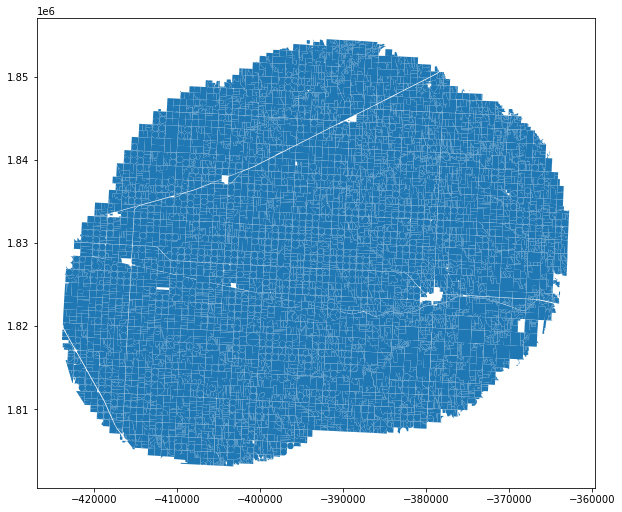

In [28]:
fig, ax = plt.subplots(figsize = (10,10))
fields.plot(ax=ax)
plt.show()

### SD6KS Boundary Shapefile

In [29]:
boundary_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Management Districts\\Kansas\\"
os.chdir(boundary_fp)
boundary = gpd.read_file('Boundary_SD6KS_BWilson_20220616.shp')

In [30]:
boundary_coords = shp.Reader("Boundary_SD6KS_BWilson_20220616.shp")
boundary_coords.bbox

[346774.9221245285, 4352264.910569741, 375914.3972205508, 4371371.047506346]

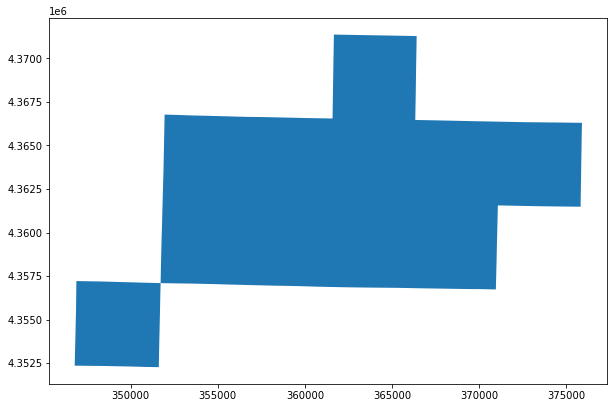

In [31]:
fig, ax = plt.subplots(figsize = (10,10))
boundary.plot(ax=ax)
plt.show()

### SD6KS Buffer Shapefile

In [32]:
buffer_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Management Districts\\Kansas\\"
os.chdir(buffer_fp)
buffer = gpd.read_file('BoundaryBuffer_SD6KS_BWilson_20220616.shp')

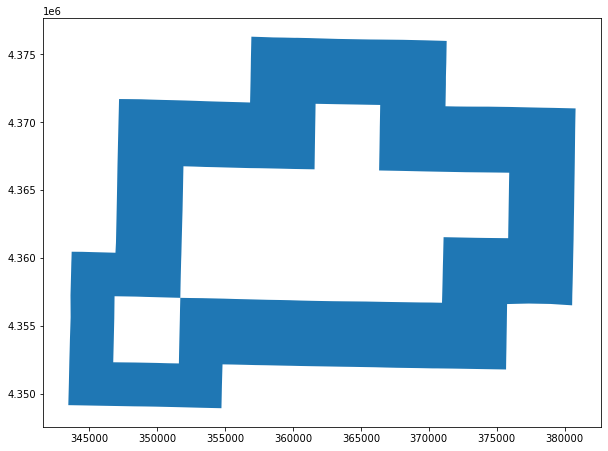

In [33]:
fig, ax = plt.subplots(figsize = (10,10))
buffer.plot(ax=ax)
plt.show()

### Overlaying Shapefiles

In [34]:
# Change boundary and buffer to same CRS as fields so they can be layered on top
boundary = boundary.to_crs(fields.crs)
buffer = buffer.to_crs(fields.crs)

<AxesSubplot:>

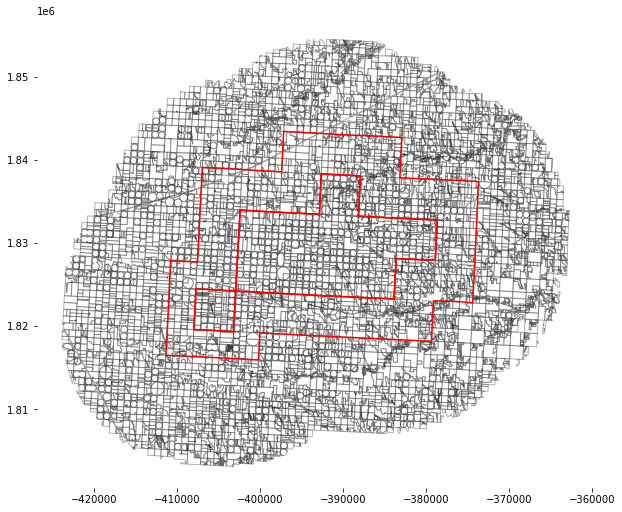

In [35]:
fig, ax = plt.subplots(figsize = (10,10))

# Set the base as the fields shapefile
base = fields.plot(ax=ax, color='white', edgecolor='k', alpha=0.3)
ax.spines['top'].set_visible(False) # remove border around plot
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Plot the boundary and buffer on top of fields, setting the ax = base
# Set color of the line to black
boundary.boundary.plot(ax=base, color='red')
buffer.boundary.plot(ax=base, color='red')

### Clipping to LEMA

In [233]:
lema = gpd.clip(fields, boundary)

### OpenET Data (mm, annually by field)

In [36]:
# Create a filepath for OpenET data and change working directory
openET_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Hydrometeorology\\OpenET\\"
os.chdir(openET_fp)

In [37]:
# Import ensemble file from OpenET
ensemble = pd.read_csv('ET_monthly_ensemble_FieldsAroundSD6KS_20220708.csv')

# Import DisALEXI file from OpenET
disalexi = pd.read_csv('ET_monthly_disalexi_FieldsAroundSD6KS_20220708.csv')

# Import eeMetric file from OpenET
eemetric = pd.read_csv('ET_monthly_eemetric_FieldsAroundSD6KS_20220708.csv')

# Import geeSEBAL file from OpenET
geesebal = pd.read_csv('ET_monthly_geesebal_FieldsAroundSD6KS_20220708.csv')

# Import PT-JPL file from OpenET
ptjpl = pd.read_csv('ET_monthly_ptjpl_FieldsAroundSD6KS_20220708.csv')

# Import SIMS file from OpenET
sims = pd.read_csv('ET_monthly_sims_FieldsAroundSD6KS_20220708.csv')

# Import SSEBop file from OpenET
ssebop = pd.read_csv('ET_monthly_ssebop_FieldsAroundSD6KS_20220708.csv')

In [38]:
# Create lists for the following for loop
et = [ensemble, disalexi, eemetric, geesebal, ptjpl, sims, ssebop]
lab = ['annual_ensemble', 'annual_disalexi', 'annual_eemetric', 'annual_geesebal', 'annual_ptjpl', 'annual_sims', 'annual_ssebop']

In [39]:
# Create a dictionary to store dataframes in
annual_et = {}

i = 0 # Used to set first index for lab

# Use a for loop to wrangle data from monthly into annual data (NOTE: WILL TAKE ~10-11 MINS TO RUN)
for x in et:
    x.drop('acres', inplace = True, axis = 1) # drop irrelevant columns
    merge_x = fields.merge(x, on = 'UID', how = 'left') # merge dataframes and shapefile together
    x_fields = gpd.GeoDataFrame(merge_x) # turn into geodataframe
    x_fields.time = pd.to_datetime(x_fields.time).dt.strftime('%Y') # change time column to datetime
    annual_et[lab[i]] = x_fields.dissolve(by = ['UID', 'time'], aggfunc = 'sum') # assign to dictionary, group by UID and time and sum the rest of the columns
    annual_et[lab[i]].drop('area', inplace = True, axis = 1) # drop irrelevant columns
    annual_et[lab[i]].reset_index(inplace=True) # ungroup from index format
    i += 1 # since index for lab was set to 0, this adds 1 to each iteration of for loop

In [40]:
# Change the names so that they are easier to call
annual_ensemble = annual_et['annual_ensemble']
annual_disalexi = annual_et['annual_disalexi']
annual_eemetric = annual_et['annual_eemetric']
annual_geesebal = annual_et['annual_geesebal']
annual_ptjpl = annual_et['annual_ptjpl']
annual_ssebop = annual_et['annual_ssebop']
annual_sims = annual_et['annual_sims']

### gridMET Data (mm, annually by field)

In [41]:
# Create gridMET filepath and change working directory
gridmet_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Hydrometeorology\\gridMET\\"
os.chdir(gridmet_fp)

# Read in gridmet file
gridmet = pd.read_csv('DailyMet_FieldsAroundSD6KS_2016-2021_20220802.csv')

In [42]:
# Change date_ymd column to datetime format
gridmet["date_ymd"] = pd.to_datetime(gridmet["date_ymd"], format='%Y%m%d')

In [43]:
gridmet.drop(['eto', 'etr'], inplace = True, axis = 1) # drop irrelevant columns

In [44]:
# Simplify date column to just years
gridmet.date_ymd = pd.to_datetime(gridmet.date_ymd).dt.strftime('%Y')

In [45]:
# Create annual precipitation dataframe
annual_gridmet = gridmet.groupby(['UID','date_ymd'])['pr'].sum().reset_index()

In [46]:
# Merge with shapefile
annual_gridmet = gpd.GeoDataFrame(fields.merge(annual_gridmet, on = 'UID', how = 'left'))

In [47]:
annual_gridmet.drop('area', inplace = True, axis = 1) # drop irrelevant columns

In [48]:
# Rename column to time instead of date_ymd
annual_gridmet = annual_gridmet.rename({'date_ymd': 'time'}, axis=1)

### Adjusting gridMET Data into Precipitation Data by Year

In [49]:
# Pivot dataset so that the columns represent the years and the values are the precip
gridmet_pivot = gpd.GeoDataFrame(annual_gridmet.pivot(index = 'UID', columns = 'time', values = 'pr'))
gridmet_pivot.reset_index(inplace = True) # reset the index
gridmet_pivot.columns = gridmet_pivot.columns.astype(str) # change column types to strings
gridmet_pivot = gridmet_pivot[['UID', '2016', '2017', '2018', '2019', '2020', '2021']] # Select relevant columns

In [50]:
# Check for NaN values and create new dataframe that only has NaN values
gridmet_null = gridmet_pivot[gridmet_pivot.isna().any(axis=1)] # there are 20 rows that are NaN

In [51]:
# Merge with fields shapefile
gridmet_null = fields.merge(gridmet_null, on = 'UID')
# Select relevant columns and just make sure it's a gpd
gridmet_null = gpd.GeoDataFrame(gridmet_null[['UID', 'geometry']])

In [52]:
# Create new dataframe by copying old one
grid_null = gridmet_null.copy()
# Create centroid column to find the centroid of each polygon so that the geometry is in point form
grid_null['centroid'] = grid_null.to_crs('epsg:4326').centroid.to_crs(grid_null.crs)
# Find the longitude and latitude of each polygon
grid_null['lon'] = grid_null['geometry'].to_crs('epsg:4326').centroid.x
grid_null['lat'] = grid_null['geometry'].to_crs('epsg:4326').centroid.y
# Make sure it's all in the same CRS of EPSG 4326
grid_null = grid_null.to_crs(epsg=4326)

C:\Users\ashle\AppData\Local\Temp\ipykernel_14908\3811171553.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_null['centroid'] = grid_null.to_crs('epsg:4326').centroid.to_crs(grid_null.crs)
C:\Users\ashle\AppData\Local\Temp\ipykernel_14908\3811171553.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_null['lon'] = grid_null['geometry'].to_crs('epsg:4326').centroid.x
C:\Users\ashle\AppData\Local\Temp\ipykernel_14908\3811171553.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_null['lat'] = grid_null['geometry'].to_crs('epsg:4326').centroid.y


In [53]:
# Select relevant columns
grid_null = grid_null[['UID', 'centroid', 'lon', 'lat']]
# Rename the centroid column to geometry
grid_null = grid_null.rename({'UID':'UID_null','centroid': 'geometry'}, axis=1)

In [54]:
# Set crs to EPSG 4326
crs = {'init': 'epsg:4326'}
# Set geometry so that the points are equal to the lat and long
from shapely import geometry
geometry = [geometry.Point(xy) for xy in zip(grid_null['lon'], grid_null['lat'])]

In [55]:
# Once again just make sure everything is in the correct format
grid_null = gpd.GeoDataFrame(grid_null, crs=crs, geometry=geometry)

C:\Users\ashle\anaconda3\envs\eggs\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [56]:
# Create new dataframe made up of fields that don't contain NaN
gridmet_val = gridmet_pivot.dropna()

In [57]:
# Merge with fields geodataframe
gridmet_val = fields.merge(gridmet_val, on = 'UID') # merge with shapefile
gridmet_val = gpd.GeoDataFrame(gridmet_val) # merge with shapefile
gridmet_val = gpd.GeoDataFrame(gridmet_val[['UID', 'geometry']]) # select relevant columns

In [58]:
# Create new dataframe by copying old one
grid_val = gridmet_val.copy()
# Create centroid column to find the centroid of each polygon so that the geometry is in point form
grid_val['centroid'] = grid_val.to_crs('epsg:4326').centroid.to_crs(grid_val.crs)
# Find the longitude and latitude of each polygon
grid_val['lon'] = grid_val['geometry'].to_crs('epsg:4326').centroid.x
grid_val['lat'] = grid_val['geometry'].to_crs('epsg:4326').centroid.y
# Make sure it's all in the same CRS of EPSG 4326
grid_val = grid_val.to_crs(epsg=4326)

C:\Users\ashle\AppData\Local\Temp\ipykernel_14908\3605842926.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_val['centroid'] = grid_val.to_crs('epsg:4326').centroid.to_crs(grid_val.crs)
C:\Users\ashle\AppData\Local\Temp\ipykernel_14908\3605842926.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_val['lon'] = grid_val['geometry'].to_crs('epsg:4326').centroid.x
C:\Users\ashle\AppData\Local\Temp\ipykernel_14908\3605842926.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_val['lat'] = grid_val['geometry'].to_crs('epsg:4326').centroid.y


In [59]:
# Select relevant columns
grid_val = grid_val[['UID', 'centroid', 'lon', 'lat']]
# Rename the centroid column to geometry
grid_val = grid_val.rename({'centroid': 'geometry'}, axis=1)

In [60]:
# Set crs to EPSG 4326
crs = {'init': 'epsg:4326'}
# Set geometry so that the points are equal to the lat and long
from shapely import geometry
geom = [geometry.Point(xy) for xy in zip(grid_val['lon'], grid_val['lat'])]

In [61]:
# Once again just make sure everything is in the correct format
grid_val = gpd.GeoDataFrame(grid_val, crs=crs, geometry=geom)

C:\Users\ashle\anaconda3\envs\eggs\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [62]:
# Nearest neighbor script and helper functions using haversine distance formula
from sklearn.neighbors import BallTree

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance if requested 
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

In [63]:
# Apply helper function to find nearest neighbor for each null data point
nearest_field = nearest_neighbor(grid_null, grid_val, return_dist=True)

In [64]:
# Make sure UID_null type is float
grid_null['UID_null'] = grid_null['UID_null'].astype('float')

In [65]:
# Join grid_null and nearest_field together since the UID in nearest_field represents the UID_null in grid_null
join_uid = pd.DataFrame(pd.concat([grid_null['UID_null'], nearest_field['UID']],
                                  axis=1, 
                                  keys=['UID_null', 'UID']))

In [66]:
# Create new dataframe made up of fields that don't contain NaN again
update_val = gridmet_pivot.dropna()
# Merge with fields geodataframe
update_val = gpd.GeoDataFrame(fields.merge(update_val, on = 'UID'))
# Drop irrelevant columns
update_val.drop('area', inplace=True, axis=1)

In [67]:
# Merge update_val with join_uid to create df that has precip values
null_merge = join_uid.merge(update_val, on = 'UID')
# Drop UID column so that UID_null fields match with precip values
null_merge = null_merge[['UID_null', '2016', '2017', '2018', '2019', '2020', '2021']]

In [68]:
# Create precip df by setting the indices to UID so that they merge correctly
precip = gridmet_pivot.set_index('UID')
precip = precip.fillna(null_merge.set_index('UID_null')) # merge with null_merge df to use adjusted values
precip.reset_index(inplace=True) # reset index
# Check for NaN values
# nullcheck = precip[precip.isna().any(axis=1)] # there are no rows with NaN anymore

In [69]:
precip = gpd.GeoDataFrame(fields.merge(precip, on = 'UID', how = 'left')) # merge with shapefile
precip.drop('area', inplace=True, axis=1) # drop irrelevant columns

### Irrigation Status (%, anuually by field)

In [394]:
# Create irrigation status filepath and change working directory
aim_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Irrigation Status"
os.chdir(aim_fp)

# Read in AIM file and filter out years less than 2016
aim = pd.read_csv('FieldsAttributes_FieldsAroundSD6KS_Irrigation_AnnualAIM.csv')

In [395]:
# Pivot dataset so that the columns represent the years and the values are the precip
aim_adjust = aim[aim['Year'] > 2015]
aim_pivot = aim_adjust.pivot(index = 'UID', columns = 'Year', values = 'IrrigatedPrc')
aim_pivot.reset_index(inplace = True) # reset the index
aim_pivot.columns = aim_pivot.columns.astype(str) # set column names as strings
aim_pivot.UID = aim_pivot.UID.astype('float') # set UID values as floats

In [72]:
# Any field 0.5 and above is considered irrigated, anything below is rainfed

# 2016 Irrigated & Rainfed Fields
aim_irr_2016 = aim_pivot[aim_pivot['2016'] >= 0.5]
aim_irr_2016 = aim_irr_2016[['UID']]
aim_rain_2016 = aim_pivot[aim_pivot['2016'] < 0.5]
aim_rain_2016 = aim_rain_2016[['UID']]

# 2017 Irrigated & Rainfed Fields
aim_irr_2017 = aim_pivot[aim_pivot['2017'] >= 0.5]
aim_irr_2017 = aim_irr_2017[['UID']]
aim_rain_2017 = aim_pivot[aim_pivot['2017'] < 0.5]
aim_rain_2017 = aim_rain_2017[['UID']]

# 2018 Irrigated & Rainfed Fields
aim_irr_2018 = aim_pivot[aim_pivot['2018'] >= 0.5]
aim_irr_2018 = aim_irr_2018[['UID']]
aim_rain_2018 = aim_pivot[aim_pivot['2018'] < 0.5]
aim_rain_2018 = aim_rain_2018[['UID']]

# 2019 Irrigated & Rainfed Fields
aim_irr_2019 = aim_pivot[aim_pivot['2019'] >= 0.5]
aim_irr_2019 = aim_irr_2019[['UID']]
aim_rain_2019 = aim_pivot[aim_pivot['2019'] < 0.5]
aim_rain_2019 = aim_rain_2019[['UID']]

# 2020 Irrigated & Rainfed Fields
aim_irr_2020 = aim_pivot[aim_pivot['2020'] >= 0.5]
aim_irr_2020 = aim_irr_2020[['UID']]
aim_rain_2020 = aim_pivot[aim_pivot['2020'] < 0.5]
aim_rain_2020 = aim_rain_2020[['UID']]

### Annual CDL (CropCode, pctcov, annually by field)

In [383]:
# Create annual CDL filepath
cdl_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Land Use-Land Cover"
os.chdir(cdl_fp)

In [384]:
cdl = pd.read_csv('FieldsAttributesAroundSD6KS_LandCover_AnnualCDL.csv')
cdl.UID = cdl.UID.astype('float') # set UID values as floats

### Soil Data (by field)

In [76]:
# Create soil data filepath
soil_fp = "C:\\Users\\ashle\\Desktop\\KGS\\data\\Agriculture-Land\\Soils"
os.chdir(soil_fp)

In [77]:
soil = pd.read_csv('Soil_FieldsAroundSD6KS_POLARIS_AGrinstead_20220706.csv', index_col = 0)

In [78]:
# Merge dataframe with shapefile dataframe so that it can be plotted on a map
merge_soil = fields.merge(soil, on='UID', how='left')
soil_fields = gpd.GeoDataFrame(merge_soil)

In [349]:
soil_fields.head(12)

,UID,area,geometry,depth_cm,silt_prc,sand_prc,clay_prc,thetaS_m3m3,thetaR_m3m3,logKsat_cmHr,lambda,logHB_kPa,n,logAlpha_kPa1
0,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",0-5,50.40,27.29,18.87,0.49,0.06,0.07,0.32,0.32,1.36,-0.32
1,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",5-15,49.33,26.22,20.73,0.50,0.06,0.06,0.32,0.31,1.35,-0.30
2,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",15-30,48.84,21.45,25.32,0.51,0.06,-0.01,0.30,0.33,1.31,-0.32
3,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",30-60,50.74,18.06,26.88,0.52,0.07,-0.03,0.29,0.37,1.30,-0.36
4,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",60-100,52.26,20.64,21.70,0.50,0.06,0.04,0.31,0.37,1.32,-0.36
5,177799.0,600292.444252,"POLYGON ((-414437.581 1819101.031, -414495.592...",100-200,50.15,28.27,16.29,0.49,0.05,0.24,0.34,0.25,1.38,-0.25
6,177806.0,47681.447907,"POLYGON ((-414094.454 1817341.976, -414023.919...",0-5,60.61,14.93,20.83,0.49,0.06,0.19,0.29,0.50,1.31,-0.50
7,177806.0,47681.447907,"POLYGON ((-414094.454 1817341.976, -414023.919...",5-15,60.38,14.46,21.43,0.50,0.06,0.19,0.29,0.50,1.30,-0.50
8,177806.0,47681.447907,"POLYGON ((-414094.454 1817341.976, -414023.919...",15-30,59.61,13.89,22.69,0.50,0.06,0.22,0.29,0.49,1.30,-0.49
9,177806.0,47681.447907,"POLYGON ((-414094.454 1817341.976, -414023.919...",30-60,58.66,13.90,23.27,0.50,0.06,0.23,0.29,0.49,1.30,-0.49


In [ ]:
soil_05
soil_515
soil_1530
soil_3060
soil_60100

## Graphs & New Datasets

### Annual Mean ET

In [80]:
# Create a list of strings to name the columns for ame
column_names = ['UID', 
           'time', 
           'geometry', 
           'ensemble_et_mean', 
           'disalexi_et_mean', 
           'eemetric_et_mean', 
           'geesebal_et_mean', 
           'ptjpl_et_mean', 
           'ssebop_et_mean', 
           'sims_et_mean']

# Create annual monthly ET dataframe by concatting columns from different ET algorithm data 
ame = gpd.GeoDataFrame(
pd.concat(
    [annual_ensemble['UID'],
     annual_ensemble['time'],
     annual_ensemble['geometry'],
     annual_ensemble['et_mean'],
     annual_disalexi['et_mean'],
     annual_eemetric['et_mean'],
     annual_geesebal['et_mean'],
     annual_ptjpl['et_mean'],
     annual_ssebop['et_mean'],
     annual_sims['et_mean']],
axis=1,
keys=column_names)
)

In [81]:
# Create a list for the following for loop 
col = ['ensemble_et_mean', 
           'disalexi_et_mean', 
           'eemetric_et_mean', 
           'geesebal_et_mean', 
           'ptjpl_et_mean', 
           'ssebop_et_mean', 
           'sims_et_mean']

# Create a dictionary using a for loop to make a dataframe for each ET algorithm
annual_mean_et = dict()

for x in col:
    annual_mean_et[x] = gpd.GeoDataFrame(
pd.concat(
    [ame['UID'],
     ame['time'],
     ame['geometry'],
     ame[x]
    ],
    axis = 1,
    keys = ['UID', 
           'time', 
           'geometry', 
           str(x)])
)

In [82]:
# Create a dictionary using a for loop to merge dataframe
mean_et = dict()

for i in col:
    df = gpd.GeoDataFrame(annual_mean_et[i].pivot(index = 'UID', columns = 'time', values = str(i))) # make year data wider
    merging = fields.merge(df, on = 'UID', how = 'left') # merge with shapefile
    mean_et[i] = gpd.GeoDataFrame(merging) # merge with shapefile
    mean_et[i].drop('area', inplace=True, axis=1) # drop irrelevant columns

In [83]:
# Create variables easier to call
mean_ensemble = mean_et['ensemble_et_mean']
mean_disalexi = mean_et['disalexi_et_mean']
mean_eemetric = mean_et['eemetric_et_mean']
mean_geesebal = mean_et['geesebal_et_mean']
mean_ptjpl = mean_et['ptjpl_et_mean']
mean_ssebop = mean_et['ssebop_et_mean']
mean_sims = mean_et['sims_et_mean']

In [84]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
mean_et_list = [mean_ensemble, mean_disalexi, mean_eemetric, mean_geesebal, mean_ptjpl, mean_ssebop, mean_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

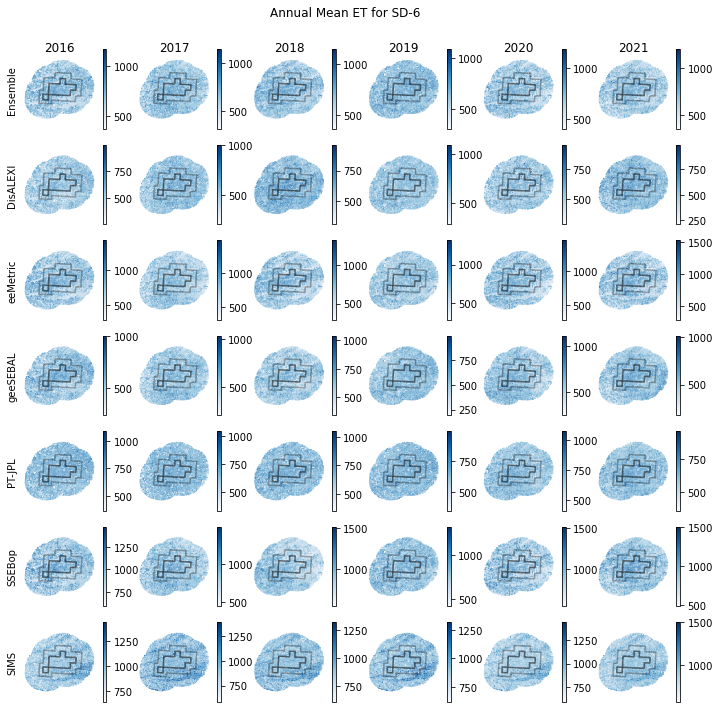

In [85]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))
fig.suptitle('Annual Mean ET for SD-6', y=0.93)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 7
cols = 6
for r in range(rows):
    for c in range(cols):
        et = mean_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues', legend=True)
        boundary.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        axs[r,c].patch.set_facecolor('white')
        axs[r,c].set_xticks([]) # remove tick marks 
        axs[r,c].set_xticklabels([]) # remove tick mark labels
        axs[r,c].set_yticks([])
        axs[r,c].set_yticklabels([])
        axs[r,c].spines['top'].set_visible(False) # remove border around plot
        axs[r,c].spines['right'].set_visible(False)
        axs[r,c].spines['bottom'].set_visible(False)
        axs[r,c].spines['left'].set_visible(False)
        if c == 0:
            axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
        if r == 0:
            axs[r,c].set_title(years[c]) # set year titles for each column

# fig.colorbar(cm.ScalarMappable(cmap='Blues'), ax=axs[r,c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\')
plt.savefig('AnnualMeanETSD6.png', dpi=500)
plt.show()

### Annual Min ET 

In [86]:
# Create a list of strings to name the columns for ame
column_names = ['UID', 
           'time', 
           'geometry', 
           'ensemble_et_min', 
           'disalexi_et_min', 
           'eemetric_et_min', 
           'geesebal_et_min', 
           'ptjpl_et_min', 
           'ssebop_et_min', 
           'sims_et_min']

# Create annual monthly ET dataframe by concatting columns from different ET algorithm data 
ame1 = gpd.GeoDataFrame(
pd.concat(
    [annual_ensemble['UID'],
     annual_ensemble['time'],
     annual_ensemble['geometry'],
     annual_ensemble['et_min'],
     annual_disalexi['et_min'],
     annual_eemetric['et_min'],
     annual_geesebal['et_min'],
     annual_ptjpl['et_min'],
     annual_ssebop['et_min'],
     annual_sims['et_min']],
axis=1,
keys=column_names)
)

In [87]:
# Create a list for the following for loop made up of 
col = ['ensemble_et_min', 
           'disalexi_et_min', 
           'eemetric_et_min', 
           'geesebal_et_min', 
           'ptjpl_et_min', 
           'ssebop_et_min', 
           'sims_et_min']

# Create a dictionary using a for loop to make a dataframe for each ET algorithm
annual_min_et = dict()

for x in col:
    annual_min_et[x] = gpd.GeoDataFrame(
pd.concat(
    [ame1['UID'],
     ame1['time'],
     ame1['geometry'],
     ame1[x]
    ],
    axis = 1,
    keys = ['UID', 
           'time', 
           'geometry', 
           str(x)])
)

In [88]:
# Create a dictionary using a for loop to merge dataframe
min_et = dict()

for i in col:
    df1 = gpd.GeoDataFrame(annual_min_et[i].pivot(index = 'UID', columns = 'time', values = str(i))) # make year data wider
    merging = fields.merge(df1, on = 'UID', how = 'left') # merge with shapefile
    min_et[i] = gpd.GeoDataFrame(merging) # merge with shapefile
    min_et[i].drop('area', inplace=True, axis=1) # drop irrelevant columns

In [89]:
# Create variables easier to call
min_ensemble = min_et['ensemble_et_min']
min_disalexi = min_et['disalexi_et_min']
min_eemetric = min_et['eemetric_et_min']
min_geesebal = min_et['geesebal_et_min']
min_ptjpl = min_et['ptjpl_et_min']
min_ssebop = min_et['ssebop_et_min']
min_sims = min_et['sims_et_min']

In [90]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
min_et_list = [min_ensemble, min_disalexi, min_eemetric, min_geesebal, min_ptjpl, min_ssebop, min_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

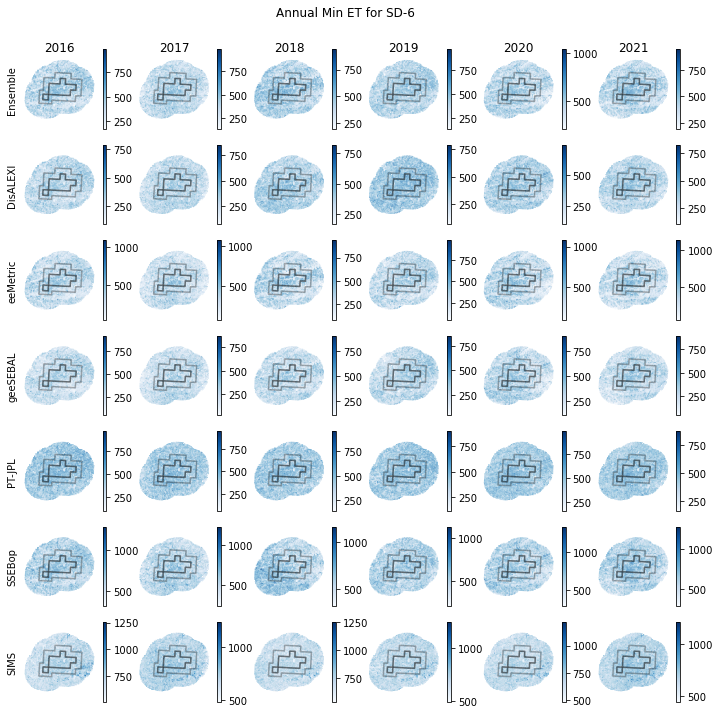

In [91]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))
fig.suptitle('Annual Min ET for SD-6', y=0.93)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 7
cols = 6
for r in range(rows):
    for c in range(cols):
        et = min_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues', legend=True)
        boundary.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        axs[r,c].patch.set_facecolor('white')
        axs[r,c].set_xticks([]) # remove tick marks 
        axs[r,c].set_xticklabels([]) # remove tick mark labels
        axs[r,c].set_yticks([])
        axs[r,c].set_yticklabels([])
        axs[r,c].spines['top'].set_visible(False) # remove border around plot
        axs[r,c].spines['right'].set_visible(False)
        axs[r,c].spines['bottom'].set_visible(False)
        axs[r,c].spines['left'].set_visible(False)
        if c == 0:
            axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
        if r == 0:
            axs[r,c].set_title(years[c]) # set year titles for each column

# fig.colorbar(cm.ScalarMappable(cmap='Blues'), ax=axs[r,c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\')
plt.savefig('AnnualMinETSD6.png', dpi=500)
plt.show()

### Annual Max ET

In [92]:
# Create a list of strings to name the columns for ame
column_names = ['UID', 
           'time', 
           'geometry', 
           'ensemble_et_max', 
           'disalexi_et_max', 
           'eemetric_et_max', 
           'geesebal_et_max', 
           'ptjpl_et_max', 
           'ssebop_et_max', 
           'sims_et_max']

# Create annual monthly ET dataframe by concatting columns from different ET algorithm data 
ame2 = gpd.GeoDataFrame(
pd.concat(
    [annual_ensemble['UID'],
     annual_ensemble['time'],
     annual_ensemble['geometry'],
     annual_ensemble['et_max'],
     annual_disalexi['et_max'],
     annual_eemetric['et_max'],
     annual_geesebal['et_max'],
     annual_ptjpl['et_max'],
     annual_ssebop['et_max'],
     annual_sims['et_max']],
axis=1,
keys=column_names)
)

In [93]:
# Create a list for the following for loop made up of 
col = ['ensemble_et_max', 
           'disalexi_et_max', 
           'eemetric_et_max', 
           'geesebal_et_max', 
           'ptjpl_et_max', 
           'ssebop_et_max', 
           'sims_et_max']

# Create a dictionary using a for loop to make a dataframe for each ET algorithm
annual_max_et = dict()

for x in col:
    annual_max_et[x] = gpd.GeoDataFrame(
pd.concat(
    [ame2['UID'],
     ame2['time'],
     ame2['geometry'],
     ame2[x]
    ],
    axis = 1,
    keys = ['UID', 
           'time', 
           'geometry', 
           str(x)])
)

In [94]:
# Create a dictionary using a for loop to merge dataframe
max_et = dict()

for i in col:
    df1 = gpd.GeoDataFrame(annual_max_et[i].pivot(index = 'UID', columns = 'time', values = str(i))) # make year data wider
    merging = fields.merge(df1, on = 'UID', how = 'left') # merge with shapefile
    max_et[i] = gpd.GeoDataFrame(merging) # merge with shapefile
    max_et[i].drop('area', inplace=True, axis=1) # drop irrelevant columns

In [95]:
# Create variables easier to call
max_ensemble = max_et['ensemble_et_max']
max_disalexi = max_et['disalexi_et_max']
max_eemetric = max_et['eemetric_et_max']
max_geesebal = max_et['geesebal_et_max']
max_ptjpl = max_et['ptjpl_et_max']
max_ssebop = max_et['ssebop_et_max']
max_sims = max_et['sims_et_max']

In [96]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
max_et_list = [max_ensemble, max_disalexi, max_eemetric, max_geesebal, max_ptjpl, max_ssebop, max_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

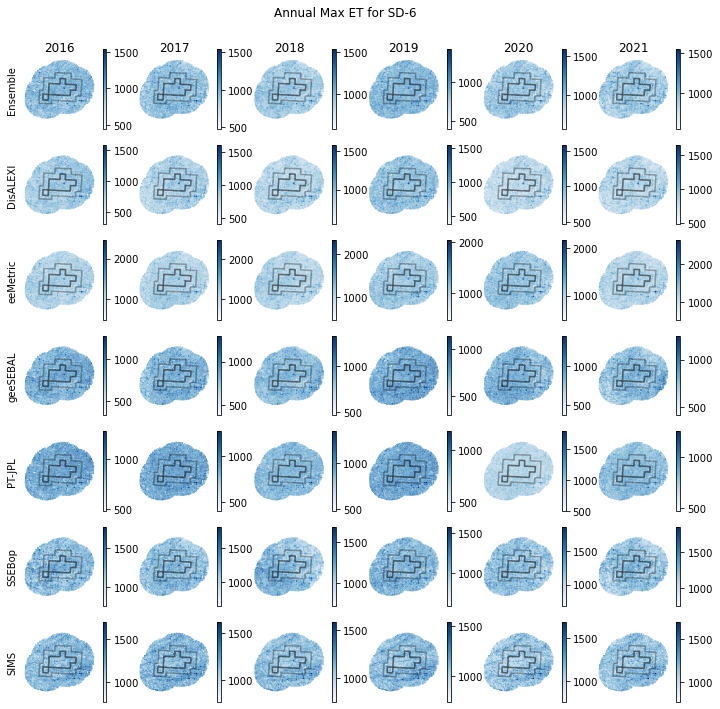

In [97]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))
fig.suptitle('Annual Max ET for SD-6', y=0.93)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 7
cols = 6
for r in range(rows):
    for c in range(cols):
        et = max_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues', legend=True)
        boundary.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        axs[r,c].patch.set_facecolor('white')
        axs[r,c].set_xticks([]) # remove tick marks 
        axs[r,c].set_xticklabels([]) # remove tick mark labels
        axs[r,c].set_yticks([])
        axs[r,c].set_yticklabels([])
        axs[r,c].spines['top'].set_visible(False) # remove border around plot
        axs[r,c].spines['right'].set_visible(False)
        axs[r,c].spines['bottom'].set_visible(False)
        axs[r,c].spines['left'].set_visible(False)
        if c == 0:
            axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
        if r == 0:
            axs[r,c].set_title(years[c]) # set year titles for each column

# fig.colorbar(cm.ScalarMappable(cmap='Blues'), ax=axs[r,c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\')
plt.savefig('AnnualMaxETSD6.png', dpi=500)
plt.show()

### Annual % Irrigated Fields for SD-6

In [98]:
aim_years = gpd.GeoDataFrame(fields.merge(aim_pivot, on = 'UID', how = 'left'))
aim_years.drop('area', inplace=True, axis=1)

In [99]:
# Create list that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020']

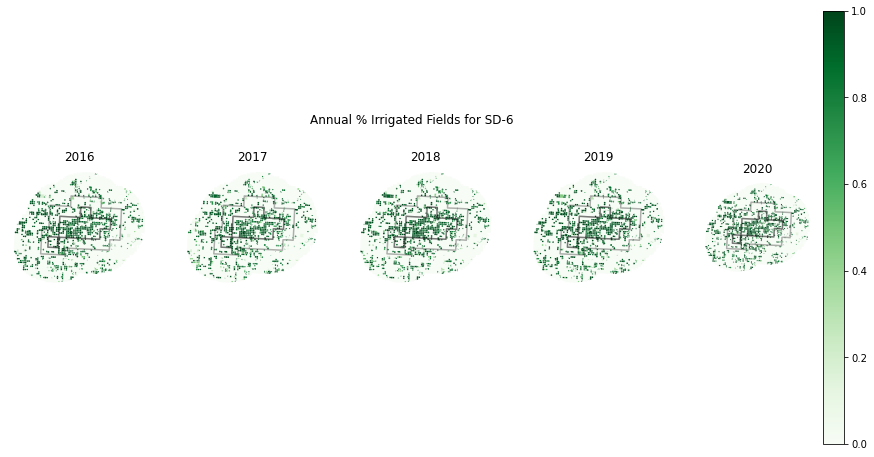

In [100]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 1, ncols = 5, figsize = (15, 8))
fig.suptitle('Annual % Irrigated Fields for SD-6', y=0.70)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 1
cols = 5
for r in range(rows):
    for c in range(cols):
        y = years[c]
        aim = aim_years.plot(aim_years[y], ax=axs[c], cmap='Greens')
        boundary.boundary.plot(ax=axs[c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[c], color='k', alpha=0.3)
        axs[c].patch.set_facecolor('white')
        axs[c].set_xticks([]) # remove tick marks 
        axs[c].set_xticklabels([]) # remove tick mark labels
        axs[c].set_yticks([])
        axs[c].set_yticklabels([])
        axs[c].spines['top'].set_visible(False) # remove border around plot
        axs[c].spines['right'].set_visible(False)
        axs[c].spines['bottom'].set_visible(False)
        axs[c].spines['left'].set_visible(False)
        axs[c].set_title(y) # set year titles for each column

fig.colorbar(cm.ScalarMappable(cmap='Greens'), ax=axs[c])

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\')
plt.savefig('AnnualIrrigatedFieldsSD6.png', dpi=500)
plt.show()

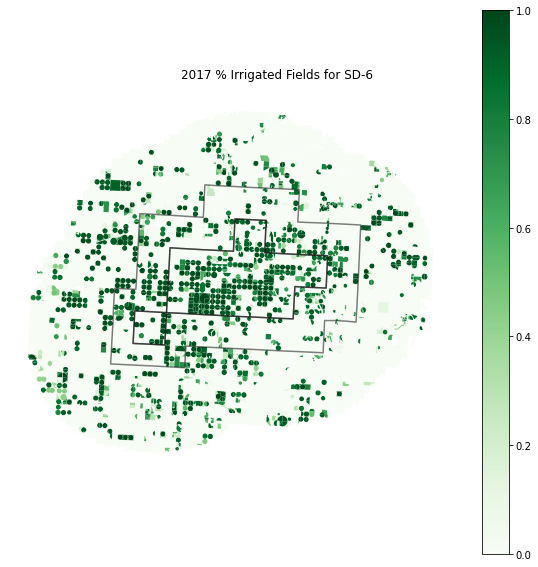

In [227]:
fig, axs = plt.subplots(figsize=(10,10))
fig.suptitle('2017 % Irrigated Fields for SD-6', y=0.80)
fig.patch.set_facecolor('white')

aim_years.plot(aim_years['2017'], ax=axs, legend=True, cmap='Greens')
boundary.boundary.plot(ax=axs, color='k', alpha=0.5)
buffer.boundary.plot(ax=axs, color='k', alpha=0.5)
axs.patch.set_facecolor('white')
axs.set_xticks([]) # remove tick marks 
axs.set_xticklabels([]) # remove tick mark labels
axs.set_yticks([])
axs.set_yticklabels([])
axs.spines['top'].set_visible(False) # remove border around plot
axs.spines['right'].set_visible(False)
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)

### Annual Crop Data

In [140]:
# Create lists of crop codes, crop names, and crop groups to match them up in a single dataframe
crop_code = [1, 4, 5, 6, 24, 61, 510, 520, 530, 540, 550, 560, 21, 23, 25, 27, 28, 29, 205, 2, 31, 33, 42, 43, 53, 
             26, 225, 226, 235, 236, 237, 238]

crop_name = ["Corn", 
             "Sorghum", 
             "Soybeans", 
             "Sunflower", 
             "Winter Wheat",
             "Fallow/Idle",
             "Alfalfa/Hay",
             "Grass/Shrub",
             "Forest", 
             "Wetland", 
             "Developed", 
             "Barren/Water", 
             "Barley", 
             "Spring Wheat", 
             "Other Small Grains", 
             "Rye", 
             "Oats", 
             "Millet", 
             "Triticale",
             "Cotton", 
             "Canola", 
             "Safflower", 
             "Dry Beans", 
             "Potatoes", 
             "Peas", 
             "Dbl Crop WinWht/Soybeans", 
             "Dbl_Crop_WinWht/Corn", 
             "Dbl Crop Oats/Corn", 
             "Dbl Crop Barley/Sorghum", 
             "Dbl Crop WinWht/Sorghum", 
             "Dbl_Crop_Barley/Corn", 
             "Dbl Crop WinWht/Cotton"]

crop_group = ["Corn", 
              "Sorghum", 
              "Soybeans",
              "Sunflower", 
              "Winter Wheat", 
              "Fallow/Idle", 
              "Alfalfa/Hay", 
              "Grass/Shrub", 
              "Forest", 
              "Wetland", 
              "Developed", 
              "Barren/Water", 
              "Other Small Grains",
              "Other Small Grains",
              "Other Small Grains",
              "Other Small Grains",
              "Other Small Grains",
              "Other Small Grains",
              "Other Small Grains",
              "Other Crops",
              "Other Crops",
              "Other Crops",
              "Other Crops",
              "Other Crops",
              "Other Crops",
              "Double Crop", 
              "Double Crop",
              "Double Crop",
              "Double Crop",
              "Double Crop",
              "Double Crop",
              "Double Crop"]

In [141]:
# Create crop dataframe 
crops = pd.DataFrame(zip(crop_code, crop_name, crop_group), columns=['CropCode', 'CropName', 'CropGroup'])

In [229]:
# Merge the fields that are considered irrigated by AIM with CDL data and separate by year
cdl_adjust = cdl[cdl['Year'] > 2015]

# 2016 Irrigated Crops
irrigated_crop_2016 = aim_irr_2016.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2016 = irrigated_crop_2016[irrigated_crop_2016['Year'] == 2016]
irr_crop_2016 = irrigated_crop_2016.merge(crops, on='CropCode').sort_values('CropGroup')

# 2017 Irrigated Crops
irrigated_crop_2017 = aim_irr_2017.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2017 = irrigated_crop_2017[irrigated_crop_2017['Year'] == 2017]
irr_crop_2017 = irrigated_crop_2017.merge(crops, on='CropCode').sort_values('CropGroup')

# 2018 Irrigated Crops
irrigated_crop_2018 = aim_irr_2018.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2018 = irrigated_crop_2018[irrigated_crop_2018['Year'] == 2018]
irr_crop_2018 = irrigated_crop_2018.merge(crops, on='CropCode').sort_values('CropGroup')

# 2019 Irrigated Crops
irrigated_crop_2019 = aim_irr_2019.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2019 = irrigated_crop_2019[irrigated_crop_2019['Year'] == 2019]
irr_crop_2019 = irrigated_crop_2019.merge(crops, on='CropCode').sort_values('CropGroup')

# 2020 Irrigated Crops
irrigated_crop_2020 = aim_irr_2020.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2020 = irrigated_crop_2020[irrigated_crop_2020['Year'] == 2020]
irr_crop_2020 = irrigated_crop_2020.merge(crops, on='CropCode').sort_values('CropGroup')

In [230]:
# Merge the fields that are considered rainfed by AIM with CDL data and separate by year

# 2016 Rainfed Crops
rainfed_crop_2016 = aim_rain_2016.merge(cdl_adjust, on = 'UID', how = 'left')
rainfed_crop_2016 = rainfed_crop_2016[rainfed_crop_2016['Year'] == 2016]
rain_crop_2016 = rainfed_crop_2016.merge(crops, on='CropCode').sort_values('CropGroup')

# 2017 Rainfed Crops
rainfed_crop_2017 = aim_rain_2017.merge(cdl_adjust, on = 'UID', how = 'left')
rainfed_crop_2017 = rainfed_crop_2017[rainfed_crop_2017['Year'] == 2017]
rain_crop_2017 = rainfed_crop_2017.merge(crops, on='CropCode').sort_values('CropGroup')

# 2018 Rainfed Crops
rainfed_crop_2018 = aim_rain_2018.merge(cdl_adjust, on = 'UID', how = 'left')
rainfed_crop_2018 = rainfed_crop_2018[rainfed_crop_2018['Year'] == 2018]
rain_crop_2018 = rainfed_crop_2018.merge(crops, on='CropCode').sort_values('CropGroup')

# 2019 Rainfed Crops
rainfed_crop_2019 = aim_rain_2019.merge(cdl_adjust, on = 'UID', how = 'left')
rainfed_crop_2019 = rainfed_crop_2019[rainfed_crop_2019['Year'] == 2019]
rain_crop_2019 = rainfed_crop_2019.merge(crops, on='CropCode').sort_values('CropGroup')

# 2020 Rainfed Crops
rainfed_crop_2020 = aim_rain_2020.merge(cdl_adjust, on = 'UID', how = 'left')
rainfed_crop_2020 = rainfed_crop_2020[rainfed_crop_2020['Year'] == 2020]
rain_crop_2020 = rainfed_crop_2020.merge(crops, on='CropCode').sort_values('CropGroup')

In [144]:
# Create dictionary that matches crop to specific color
crop_color = {'Corn':'#ffd300', 'Sorghum':'#ff9e0a', 'Soybeans':'#267000', 'Sunflower':'#ffff00', 'Winter Wheat':'#a57000', 
              'Fallow/Idle':'#bfbf77', 'Alfalfa/Hay':'#ffa5e2', 'Grass/Shrub':'#e8ffbf', 'Forest':'#93cc93', 
              'Wetland':'#7cafaf', 'Developed':'#999999', 'Barren/Water':'#ccbfa3', 'Other Small Grains':'#d69ebc', 
              'Other Crops':'#00af49', 'Double Crop':'#707000'}

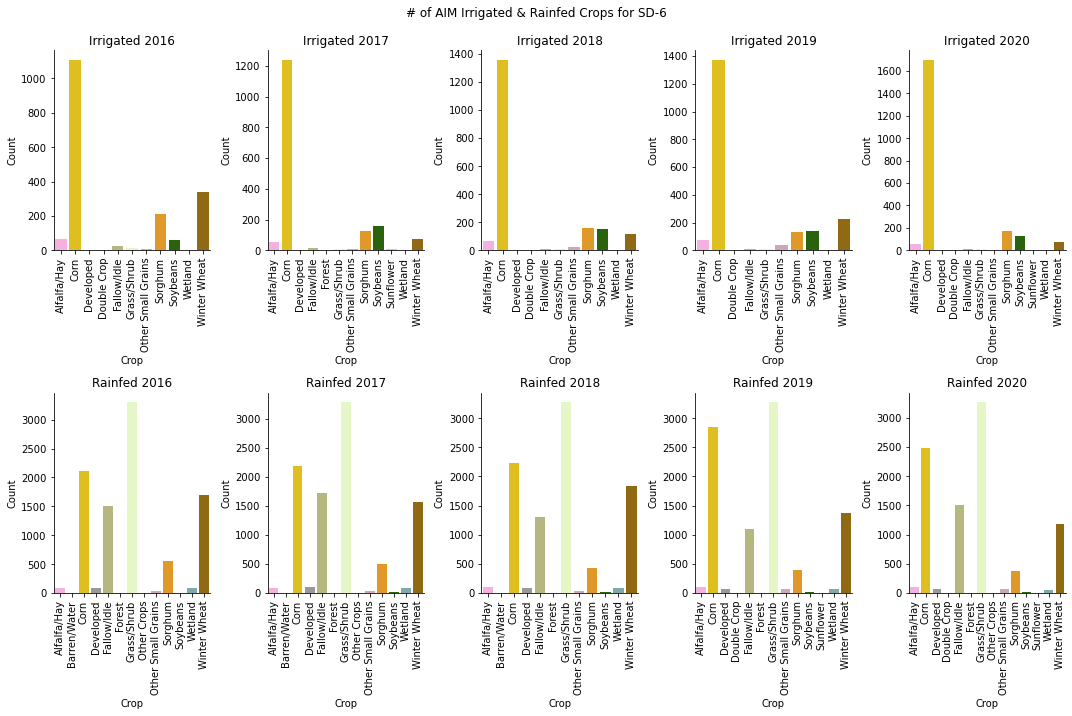

In [231]:
fig, axs = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10))
fig.suptitle('# of AIM Irrigated & Rainfed Crops for SD-6', y=0.99)
fig.patch.set_facecolor('white')

sns.countplot(ax=axs[0,0], x='CropGroup', data=irr_crop_2016, palette=crop_color)
axs[0,0].set_title("Irrigated 2016")
axs[0,0].set_xlabel("Crop")
axs[0,0].set_ylabel("Count")
axs[0,0].spines['top'].set_visible(False)
axs[0,0].spines['right'].set_visible(False)
axs[0,0].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[0,1], x='CropGroup', data=irr_crop_2017, palette=crop_color)
axs[0,1].set_title("Irrigated 2017")
axs[0,1].set_xlabel("Crop")
axs[0,1].set_ylabel("Count")
axs[0,1].spines['top'].set_visible(False)
axs[0,1].spines['right'].set_visible(False)
axs[0,1].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[0,2], x='CropGroup', data=irr_crop_2018, palette=crop_color)
axs[0,2].set_title("Irrigated 2018")
axs[0,2].set_xlabel("Crop")
axs[0,2].set_ylabel("Count")
axs[0,2].spines['top'].set_visible(False)
axs[0,2].spines['right'].set_visible(False)
axs[0,2].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[0,3], x='CropGroup', data=irr_crop_2019, palette=crop_color)
axs[0,3].set_title("Irrigated 2019")
axs[0,3].set_xlabel("Crop")
axs[0,3].set_ylabel("Count")
axs[0,3].spines['top'].set_visible(False)
axs[0,3].spines['right'].set_visible(False)
axs[0,3].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[0,4], x='CropGroup', data=irr_crop_2020, palette=crop_color)
axs[0,4].set_title("Irrigated 2020")
axs[0,4].set_xlabel("Crop")
axs[0,4].set_ylabel("Count")
axs[0,4].spines['top'].set_visible(False)
axs[0,4].spines['right'].set_visible(False)
axs[0,4].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[1,0], x='CropGroup', data=rain_crop_2016, palette=crop_color)
axs[1,0].set_title("Rainfed 2016")
axs[1,0].set_xlabel("Crop")
axs[1,0].set_ylabel("Count")
axs[1,0].spines['top'].set_visible(False)
axs[1,0].spines['right'].set_visible(False)
axs[1,0].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[1,1], x='CropGroup', data=rain_crop_2017, palette=crop_color)
axs[1,1].set_title("Rainfed 2017")
axs[1,1].set_xlabel("Crop")
axs[1,1].set_ylabel("Count")
axs[1,1].spines['top'].set_visible(False)
axs[1,1].spines['right'].set_visible(False)
axs[1,1].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[1,2], x='CropGroup', data=rain_crop_2018, palette=crop_color)
axs[1,2].set_title("Rainfed 2018")
axs[1,2].set_xlabel("Crop")
axs[1,2].set_ylabel("Count")
axs[1,2].spines['top'].set_visible(False)
axs[1,2].spines['right'].set_visible(False)
axs[1,2].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[1,3], x='CropGroup', data=rain_crop_2019, palette=crop_color)
axs[1,3].set_title("Rainfed 2019")
axs[1,3].set_xlabel("Crop")
axs[1,3].set_ylabel("Count")
axs[1,3].spines['top'].set_visible(False)
axs[1,3].spines['right'].set_visible(False)
axs[1,3].tick_params(axis='x', rotation=90)

sns.countplot(ax=axs[1,4], x='CropGroup', data=rain_crop_2020, palette=crop_color)
axs[1,4].set_title("Rainfed 2020")
axs[1,4].set_xlabel("Crop")
axs[1,4].set_ylabel("Count")
axs[1,4].spines['top'].set_visible(False)
axs[1,4].spines['right'].set_visible(False)
axs[1,4].tick_params(axis='x', rotation=90)

fig.tight_layout()

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\images\\')
plt.savefig('IrrigatedRainfedCropCount.png', dpi=500)
plt.show()

Boxplots for corn & sorghum clipped to the LEMA

In [398]:
# Set the timeframes for the LEMA
extract_aim_lema = (aim['Year'] > 2012) & (aim['Year'] < 2019)
aim_lema = aim.loc[extract_aim_lema]

# Set the timeframes for out of the LEMA
extract_aim_non_lema = (aim['Year'] > 2006) & (aim['Year'] < 2013)
aim_non_lema = aim.loc[extract_aim_non_lema]

In [407]:
aim_pivot_lema = aim_lema.pivot(index = 'UID', columns = 'Year', values = 'IrrigatedPrc')
aim_pivot_lema.reset_index(inplace = True) # reset the index
aim_pivot_lema.columns = aim_pivot_lema.columns.astype(str) # set column names as strings
aim_pivot_lema.UID = aim_pivot_lema.UID.astype('float') # set UID values as floats

aim_pivot_non_lema = aim_non_lema.pivot(index = 'UID', columns = 'Year', values = 'IrrigatedPrc')
aim_pivot_non_lema.reset_index(inplace = True) # reset the index
aim_pivot_non_lema.columns = aim_pivot_non_lema.columns.astype(str) # set column names as strings
aim_pivot_non_lema.UID = aim_pivot_non_lema.UID.astype('float') # set UID values as floats

In [408]:
# 2007 Irrigated & Rainfed Fields
aim_irr_2007 = aim_pivot_non_lema[aim_pivot_non_lema['2007'] >= 0.5]
aim_irr_2007 = aim_irr_2007[['UID']]
aim_rain_2007 = aim_pivot_non_lema[aim_pivot_non_lema['2007'] < 0.5]
aim_rain_2007= aim_rain_2007[['UID']]

# 2008 Irrigated & Rainfed Fields
aim_irr_2008 = aim_pivot_non_lema[aim_pivot_non_lema['2008'] >= 0.5]
aim_irr_2008 = aim_irr_2008[['UID']]
aim_rain_2008 = aim_pivot_non_lema[aim_pivot_non_lema['2008'] < 0.5]
aim_rain_2008= aim_rain_2008[['UID']]

# 2009 Irrigated & Rainfed Fields
aim_irr_2009 = aim_pivot_non_lema[aim_pivot_non_lema['2009'] >= 0.5]
aim_irr_2009 = aim_irr_2009[['UID']]
aim_rain_2009 = aim_pivot_non_lema[aim_pivot_non_lema['2009'] < 0.5]
aim_rain_2009= aim_rain_2009[['UID']]

# 2010 Irrigated & Rainfed Fields
aim_irr_2010 = aim_pivot_non_lema[aim_pivot_non_lema['2010'] >= 0.5]
aim_irr_2010 = aim_irr_2010[['UID']]
aim_rain_2010 = aim_pivot_non_lema[aim_pivot_non_lema['2010'] < 0.5]
aim_rain_2010= aim_rain_2010[['UID']]

# 2011 Irrigated & Rainfed Fields
aim_irr_2011 = aim_pivot_non_lema[aim_pivot_non_lema['2011'] >= 0.5]
aim_irr_2011 = aim_irr_2011[['UID']]
aim_rain_2011 = aim_pivot_non_lema[aim_pivot_non_lema['2011'] < 0.5]
aim_rain_2011= aim_rain_2011[['UID']]

# 2012 Irrigated & Rainfed Fields
aim_irr_2012 = aim_pivot_non_lema[aim_pivot_non_lema['2012'] >= 0.5]
aim_irr_2012 = aim_irr_2012[['UID']]
aim_rain_2012 = aim_pivot_non_lema[aim_pivot_non_lema['2012'] < 0.5]
aim_rain_2012= aim_rain_2012[['UID']]

In [409]:
# 2013 Irrigated & Rainfed Fields
aim_irr_2013 = aim_pivot_lema[aim_pivot_lema['2013'] >= 0.5]
aim_irr_2013 = aim_irr_2013[['UID']]
aim_rain_2013 = aim_pivot_lema[aim_pivot_lema['2013'] < 0.5]
aim_rain_2013 = aim_rain_2013[['UID']]

# 2014 Irrigated & Rainfed Fields
aim_irr_2014 = aim_pivot_lema[aim_pivot_lema['2014'] >= 0.5]
aim_irr_2014 = aim_irr_2014[['UID']]
aim_rain_2014 = aim_pivot_lema[aim_pivot_lema['2014'] < 0.5]
aim_rain_2014 = aim_rain_2014[['UID']]

# 2015 Irrigated & Rainfed Fields
aim_irr_2015 = aim_pivot_lema[aim_pivot_lema['2015'] >= 0.5]
aim_irr_2015 = aim_irr_2015[['UID']]
aim_rain_2015 = aim_pivot_lema[aim_pivot_lema['2015'] < 0.5]
aim_rain_2015 = aim_rain_2015[['UID']]

# 2016 Irrigated & Rainfed Fields
aim_irr_lema_2016 = aim_pivot_lema[aim_pivot_lema['2016'] >= 0.5]
aim_irr_lema_2016 = aim_irr_2016[['UID']]
aim_rain_lema_2016 = aim_pivot_lema[aim_pivot_lema['2016'] < 0.5]
aim_rain_lema_2016 = aim_rain_2016[['UID']]

# 2017 Irrigated & Rainfed Fields
aim_irr_lema_2017 = aim_pivot_lema[aim_pivot_lema['2017'] >= 0.5]
aim_irr_lema_2017 = aim_irr_2017[['UID']]
aim_rain_lema_2017 = aim_pivot_lema[aim_pivot_lema['2017'] < 0.5]
aim_rain_lema_2017 = aim_rain_2017[['UID']]

# 2018 Irrigated & Rainfed Fields
aim_irr_lema_2018 = aim_pivot_lema[aim_pivot_lema['2018'] >= 0.5]
aim_irr_lema_2018 = aim_irr_2018[['UID']]
aim_rain_lema_2018 = aim_pivot_lema[aim_pivot_lema['2018'] < 0.5]
aim_rain_lema_2018 = aim_rain_2018[['UID']]

In [393]:
# Set the timeframes for the LEMA
extract_cdl_lema = (cdl['Year'] > 2012) & (cdl['Year'] < 2019)
cdl_lema = cdl.loc[extract_cdl_lema]

# Set the timeframes for out of the LEMA
extract_cdl_non_lema = (cdl['Year'] > 2006) & (cdl['Year'] < 2013)
cdl_non_lema = cdl.loc[extract_cdl_non_lema]

In [378]:
irr_corn_2016 = irr_crop_2016[irr_crop_2016['CropGroup'] == 'Corn']
irr_corn_2016 = lema.merge(irr_corn_2016, on='UID')
irr_sorghum_2016 = irr_crop_2016[irr_crop_2016['CropGroup'] == 'Sorghum']
irr_sorghum_2016 = lema.merge(irr_sorghum_2016, on='UID')

In [ ]:
# 2016 Irrigated Crops
irrigated_crop_2016 = aim_irr_2016.merge(cdl_adjust, on = 'UID', how = 'left')
irrigated_crop_2016 = irrigated_crop_2016[irrigated_crop_2016['Year'] == 2016]
irr_crop_2016 = irrigated_crop_2016.merge(crops, on='CropCode').sort_values('CropGroup')

### Estimated Irrigation (mm) = ET (mean) - P Datasets

In [147]:
years = ['2016', '2017', '2018', '2019', '2020', '2021']
mean_et_list = [mean_ensemble, mean_disalexi, mean_eemetric, mean_geesebal, mean_ptjpl, mean_ssebop, mean_sims]
irr_col = ['UID', 'geometry', '2016', '2017', '2018', '2019', '2020', '2021']
mean_et_irr = ['mean_ensemble_irr', 
               'mean_disalexi_irr', 
               'mean_eemetric_irr', 
               'mean_geesebal_irr', 
               'mean_ptjpl_irr', 
               'mean_ssebop_irr', 
               'mean_sims_irr']

mean_irr = {}

for (i, x) in zip(mean_et_irr, mean_et_list):
    precip_years = precip[years] 
    mean_et = x[years]
    irr = mean_et.subtract(precip_years)
    irr.columns = irr.columns.astype(str)
    mean_irr[i] = gpd.GeoDataFrame(
        pd.concat([
            precip['UID'],
            precip['geometry'],
            irr['2016'],
            irr['2017'],
            irr['2018'],
            irr['2019'],
            irr['2020'],
            irr['2021']], 
            axis=1,
            keys=irr_col
        )
    )

In [148]:
# Create variables easier to call
irr_mean_ensemble = mean_irr['mean_ensemble_irr']
irr_mean_disalexi = mean_irr['mean_disalexi_irr']
irr_mean_eemetric = mean_irr['mean_eemetric_irr']
irr_mean_geesebal = mean_irr['mean_geesebal_irr']
irr_mean_ptjpl = mean_irr['mean_ptjpl_irr']
irr_mean_ssebop = mean_irr['mean_ssebop_irr']
irr_mean_sims = mean_irr['mean_sims_irr']

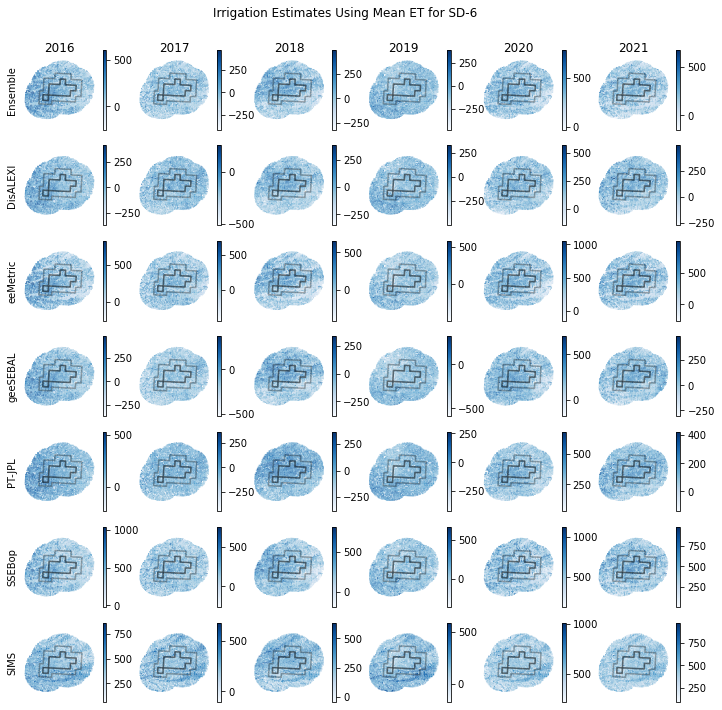

In [149]:
# Create lists that the figure can iterate through when plotting
years = ['2016', '2017', '2018', '2019', '2020', '2021']
irr_mean_et_list = [irr_mean_ensemble, irr_mean_disalexi, irr_mean_eemetric, irr_mean_geesebal, irr_mean_ptjpl, irr_mean_ssebop, irr_mean_sims]
ylab = ['Ensemble', 'DisALEXI', 'eeMetric', 'geeSEBAL', 'PT-JPL', 'SSEBop', 'SIMS']

# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 6, figsize = (12, 12))
fig.suptitle('Irrigation Estimates Using Mean ET for SD-6', y=0.93)
fig.patch.set_facecolor('white')

# Create for loop to iterate through rows and columns
rows = 7
cols = 6
for r in range(rows):
    for c in range(cols):
        et = irr_mean_et_list[r].plot(years[c], ax=axs[r,c], cmap='Blues', legend=True)
        boundary.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        buffer.boundary.plot(ax=axs[r,c], color='k', alpha=0.3)
        axs[r,c].patch.set_facecolor('white')
        axs[r,c].set_xticks([]) # remove tick marks 
        axs[r,c].set_xticklabels([]) # remove tick mark labels
        axs[r,c].set_yticks([])
        axs[r,c].set_yticklabels([])
        axs[r,c].spines['top'].set_visible(False) # remove border around plot
        axs[r,c].spines['right'].set_visible(False)
        axs[r,c].spines['bottom'].set_visible(False)
        axs[r,c].spines['left'].set_visible(False)
        if c == 0:
            axs[r,c].set_ylabel(ylab[r]) # set y-labels for first column
        if r == 0:
            axs[r,c].set_title(years[c]) # set year titles for each column

# fig.colorbar(cm.ScalarMappable(cmap='Blues'), ax=axs[r,c])

# os.chdir('C:\\Users\\ashle\\Desktop\\KGS\eggs\\')
# plt.savefig('AnnualMeanETSD6.png', dpi=500)
plt.show()

### Estimated Irrigation (mm) = ET (min) - P Datasets

In [150]:
years = ['2016', '2017', '2018', '2019', '2020', '2021']
min_et_list = [min_ensemble, min_disalexi, min_eemetric, min_geesebal, min_ptjpl, min_ssebop, min_sims]
irr_col = ['UID', 'geometry', '2016', '2017', '2018', '2019', '2020', '2021']
min_et_irr = ['min_ensemble_irr', 
               'min_disalexi_irr', 
               'min_eemetric_irr', 
               'min_geesebal_irr', 
               'min_ptjpl_irr', 
               'min_ssebop_irr', 
               'min_sims_irr']

min_irr = {}

for (i, x) in zip(min_et_irr, min_et_list):
    precip_years = precip[years] 
    min_et = x[years]
    irr = min_et.subtract(precip_years)
    irr.columns = irr.columns.astype(str)
    min_irr[i] = gpd.GeoDataFrame(
        pd.concat([
            precip['UID'],
            precip['geometry'],
            irr['2016'],
            irr['2017'],
            irr['2018'],
            irr['2019'],
            irr['2020'],
            irr['2021']], 
            axis=1,
            keys=irr_col
        )
    )

In [151]:
# Create variables easier to call
irr_min_ensemble = min_irr['min_ensemble_irr']
irr_min_disalexi = min_irr['min_disalexi_irr']
irr_min_eemetric = min_irr['min_eemetric_irr']
irr_min_geesebal = min_irr['min_geesebal_irr']
irr_min_ptjpl = min_irr['min_ptjpl_irr']
irr_min_ssebop = min_irr['min_ssebop_irr']
irr_min_sims = min_irr['min_sims_irr']

### Estimated Irrigation (mm) = ET (max) - P Datasets

In [152]:
years = ['2016', '2017', '2018', '2019', '2020', '2021']
max_et_list = [max_ensemble, max_disalexi, max_eemetric, max_geesebal, max_ptjpl, max_ssebop, max_sims]
irr_col = ['UID', 'geometry', '2016', '2017', '2018', '2019', '2020', '2021']
max_et_irr = ['max_ensemble_irr', 
               'max_disalexi_irr', 
               'max_eemetric_irr', 
               'max_geesebal_irr', 
               'max_ptjpl_irr', 
               'max_ssebop_irr', 
               'max_sims_irr']

max_irr = {}

for (i, x) in zip(max_et_irr, max_et_list):
    precip_years = precip[years] 
    max_et = x[years]
    irr = max_et.subtract(precip_years)
    irr.columns = irr.columns.astype(str)
    max_irr[i] = gpd.GeoDataFrame(
        pd.concat([
            precip['UID'],
            precip['geometry'],
            irr['2016'],
            irr['2017'],
            irr['2018'],
            irr['2019'],
            irr['2020'],
            irr['2021']], 
            axis=1,
            keys=irr_col
        )
    )

In [153]:
# Create variables easier to call
irr_max_ensemble = max_irr['max_ensemble_irr']
irr_max_disalexi = max_irr['max_disalexi_irr']
irr_max_eemetric = max_irr['max_eemetric_irr']
irr_max_geesebal = max_irr['max_geesebal_irr']
irr_max_ptjpl = max_irr['max_ptjpl_irr']
irr_max_ssebop = max_irr['max_ssebop_irr']
irr_max_sims = max_irr['max_sims_irr']

### Histograms

These histograms show the estimated irrigation data extracted to the fields considered irrigated by the AIM data against the estimated rainfed data extracted to the fields considered rainfed by the AIM data.

In [154]:
# 2016 Mean Ensemble
irr_mean_ensemble_fields_2016 = aim_irr_2016.merge(irr_mean_ensemble, how = 'left')
irr_mean_ensemble_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_ensemble_fields_2016 = aim_rain_2016.merge(irr_mean_ensemble, how = 'left')
rain_mean_ensemble_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean Ensemble
irr_mean_ensemble_fields_2017 = aim_irr_2017.merge(irr_mean_ensemble, how = 'left')
irr_mean_ensemble_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_ensemble_fields_2017 = aim_rain_2017.merge(irr_mean_ensemble, how = 'left')
rain_mean_ensemble_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean Ensemble
irr_mean_ensemble_fields_2018 = aim_irr_2018.merge(irr_mean_ensemble, how = 'left')
irr_mean_ensemble_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_ensemble_fields_2018 = aim_rain_2018.merge(irr_mean_ensemble, how = 'left')
rain_mean_ensemble_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean Ensemble
irr_mean_ensemble_fields_2019 = aim_irr_2019.merge(irr_mean_ensemble, how = 'left')
irr_mean_ensemble_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

rain_mean_ensemble_fields_2019 = aim_rain_2019.merge(irr_mean_ensemble, how = 'left')
rain_mean_ensemble_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean Ensemble
irr_mean_ensemble_fields_2020 = aim_irr_2020.merge(irr_mean_ensemble, how = 'left')
irr_mean_ensemble_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

rain_mean_ensemble_fields_2020 = aim_rain_2020.merge(irr_mean_ensemble, how = 'left')
rain_mean_ensemble_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [155]:
# 2016 Mean DisALEXI
irr_mean_disalexi_fields_2016 = aim_irr_2016.merge(irr_mean_disalexi, how = 'left')
irr_mean_disalexi_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_disalexi_fields_2016 = aim_rain_2016.merge(irr_mean_disalexi, how = 'left')
rain_mean_disalexi_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean DisALEXI
irr_mean_disalexi_fields_2017 = aim_irr_2017.merge(irr_mean_disalexi, how = 'left')
irr_mean_disalexi_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_disalexi_fields_2017 = aim_rain_2017.merge(irr_mean_disalexi, how = 'left')
rain_mean_disalexi_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean DisALEXI
irr_mean_disalexi_fields_2018 = aim_irr_2018.merge(irr_mean_disalexi, how = 'left')
irr_mean_disalexi_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_disalexi_fields_2018 = aim_rain_2018.merge(irr_mean_disalexi, how = 'left')
rain_mean_disalexi_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean DisALEXI
irr_mean_disalexi_fields_2019 = aim_irr_2019.merge(irr_mean_disalexi, how = 'left')
irr_mean_disalexi_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

rain_mean_disalexi_fields_2019 = aim_rain_2019.merge(irr_mean_disalexi, how = 'left')
rain_mean_disalexi_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean DisALEXI
irr_mean_disalexi_fields_2020 = aim_irr_2020.merge(irr_mean_disalexi, how = 'left')
irr_mean_disalexi_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

rain_mean_disalexi_fields_2020 = aim_rain_2020.merge(irr_mean_disalexi, how = 'left')
rain_mean_disalexi_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [156]:
# 2016 Mean eeMETRIC
irr_mean_eemetric_fields_2016 = aim_irr_2016.merge(irr_mean_eemetric, how = 'left')
irr_mean_eemetric_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_eemetric_fields_2016 = aim_rain_2016.merge(irr_mean_eemetric, how = 'left')
rain_mean_eemetric_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean eeMETRIC
irr_mean_eemetric_fields_2017 = aim_irr_2017.merge(irr_mean_eemetric, how = 'left')
irr_mean_eemetric_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_eemetric_fields_2017 = aim_rain_2017.merge(irr_mean_eemetric, how = 'left')
rain_mean_eemetric_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean eeMETRIC
irr_mean_eemetric_fields_2018 = aim_irr_2018.merge(irr_mean_eemetric, how = 'left')
irr_mean_eemetric_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_eemetric_fields_2018 = aim_rain_2018.merge(irr_mean_eemetric, how = 'left')
rain_mean_eemetric_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean eeMETRIC
irr_mean_eemetric_fields_2019 = aim_irr_2019.merge(irr_mean_eemetric, how = 'left')
irr_mean_eemetric_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

rain_mean_eemetric_fields_2019 = aim_rain_2019.merge(irr_mean_eemetric, how = 'left')
rain_mean_eemetric_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean eeMETRIC
irr_mean_eemetric_fields_2020 = aim_irr_2020.merge(irr_mean_eemetric, how = 'left')
irr_mean_eemetric_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

rain_mean_eemetric_fields_2020 = aim_rain_2020.merge(irr_mean_eemetric, how = 'left')
rain_mean_eemetric_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [157]:
# 2016 Mean geeSEBAL
irr_mean_geesebal_fields_2016 = aim_irr_2016.merge(irr_mean_geesebal, how = 'left')
irr_mean_geesebal_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_geesebal_fields_2016 = aim_rain_2016.merge(irr_mean_geesebal, how = 'left')
rain_mean_geesebal_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean geeSEBAL
irr_mean_geesebal_fields_2017 = aim_irr_2017.merge(irr_mean_geesebal, how = 'left')
irr_mean_geesebal_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_geesebal_fields_2017 = aim_rain_2017.merge(irr_mean_geesebal, how = 'left')
rain_mean_geesebal_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean geeSEBAL
irr_mean_geesebal_fields_2018 = aim_irr_2018.merge(irr_mean_geesebal, how = 'left')
irr_mean_geesebal_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_geesebal_fields_2018 = aim_rain_2018.merge(irr_mean_geesebal, how = 'left')
rain_mean_geesebal_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean geeSEBAL
irr_mean_geesebal_fields_2019 = aim_irr_2019.merge(irr_mean_geesebal, how = 'left')
irr_mean_geesebal_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

rain_mean_geesebal_fields_2019 = aim_rain_2019.merge(irr_mean_geesebal, how = 'left')
rain_mean_geesebal_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean geeSEBAL
irr_mean_geesebal_fields_2020 = aim_irr_2020.merge(irr_mean_geesebal, how = 'left')
irr_mean_geesebal_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

rain_mean_geesebal_fields_2020 = aim_rain_2020.merge(irr_mean_geesebal, how = 'left')
rain_mean_geesebal_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [158]:
# 2016 Mean PT-JPL
irr_mean_ptjpl_fields_2016 = aim_irr_2016.merge(irr_mean_ptjpl, how = 'left')
irr_mean_ptjpl_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_ptjpl_fields_2016 = aim_rain_2016.merge(irr_mean_ptjpl, how = 'left')
rain_mean_ptjpl_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean PT-JPL
irr_mean_ptjpl_fields_2017 = aim_irr_2017.merge(irr_mean_ptjpl, how = 'left')
irr_mean_ptjpl_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_ptjpl_fields_2017 = aim_rain_2017.merge(irr_mean_ptjpl, how = 'left')
rain_mean_ptjpl_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean PT-JPL
irr_mean_ptjpl_fields_2018 = aim_irr_2018.merge(irr_mean_ptjpl, how = 'left')
irr_mean_ptjpl_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_ptjpl_fields_2018 = aim_rain_2018.merge(irr_mean_ptjpl, how = 'left')
rain_mean_ptjpl_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean PT-JPL
irr_mean_ptjpl_fields_2019 = aim_irr_2019.merge(irr_mean_ptjpl, how = 'left')
irr_mean_ptjpl_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

rain_mean_ptjpl_fields_2019 = aim_rain_2019.merge(irr_mean_ptjpl, how = 'left')
rain_mean_ptjpl_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean PT-JPL
irr_mean_ptjpl_fields_2020 = aim_irr_2020.merge(irr_mean_ptjpl, how = 'left')
irr_mean_ptjpl_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

rain_mean_ptjpl_fields_2020 = aim_rain_2020.merge(irr_mean_ptjpl, how = 'left')
rain_mean_ptjpl_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [159]:
# 2016 Mean SSEBop
irr_mean_ssebop_fields_2016 = aim_irr_2016.merge(irr_mean_ssebop, how = 'left')
irr_mean_ssebop_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_ssebop_fields_2016 = aim_rain_2016.merge(irr_mean_ssebop, how = 'left')
rain_mean_ssebop_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean SSEBop
irr_mean_ssebop_fields_2017 = aim_irr_2017.merge(irr_mean_ssebop, how = 'left')
irr_mean_ssebop_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_ssebop_fields_2017 = aim_rain_2017.merge(irr_mean_ssebop, how = 'left')
rain_mean_ssebop_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean SSEBop
irr_mean_ssebop_fields_2018 = aim_irr_2018.merge(irr_mean_ssebop, how = 'left')
irr_mean_ssebop_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_ssebop_fields_2018 = aim_rain_2018.merge(irr_mean_ssebop, how = 'left')
rain_mean_ssebop_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean SSEBop
irr_mean_ssebop_fields_2019 = aim_irr_2019.merge(irr_mean_ssebop, how = 'left')
irr_mean_ssebop_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

rain_mean_ssebop_fields_2019 = aim_rain_2019.merge(irr_mean_ssebop, how = 'left')
rain_mean_ssebop_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean SSEBop
irr_mean_ssebop_fields_2020 = aim_irr_2020.merge(irr_mean_ssebop, how = 'left')
irr_mean_ssebop_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

rain_mean_ssebop_fields_2020 = aim_rain_2020.merge(irr_mean_ssebop, how = 'left')
rain_mean_ssebop_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

In [160]:
# 2016 Mean SIMS
irr_mean_sims_fields_2016 = aim_irr_2016.merge(irr_mean_sims, how = 'left')
irr_mean_sims_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_sims_fields_2016 = aim_rain_2016.merge(irr_mean_sims, how = 'left')
rain_mean_sims_fields_2016.drop(['2017', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2017 Mean SIMS
irr_mean_sims_fields_2017 = aim_irr_2017.merge(irr_mean_sims, how = 'left')
irr_mean_sims_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_sims_fields_2017 = aim_rain_2017.merge(irr_mean_sims, how = 'left')
rain_mean_sims_fields_2017.drop(['2016', '2018', '2019', '2020', '2021'], inplace=True, axis=1)

# 2018 Mean SIMS
irr_mean_sims_fields_2018 = aim_irr_2018.merge(irr_mean_sims, how = 'left')
irr_mean_sims_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

rain_mean_sims_fields_2018 = aim_rain_2018.merge(irr_mean_sims, how = 'left')
rain_mean_sims_fields_2018.drop(['2016', '2017', '2019', '2020', '2021'], inplace=True, axis=1)

# 2019 Mean SIMS
irr_mean_sims_fields_2019 = aim_irr_2019.merge(irr_mean_sims, how = 'left')
irr_mean_sims_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

rain_mean_sims_fields_2019 = aim_rain_2019.merge(irr_mean_sims, how = 'left')
rain_mean_sims_fields_2019.drop(['2016', '2017', '2018', '2020', '2021'], inplace=True, axis=1)

# 2020 Mean SIMS
irr_mean_sims_fields_2020 = aim_irr_2020.merge(irr_mean_sims, how = 'left')
irr_mean_sims_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

rain_mean_sims_fields_2020 = aim_rain_2020.merge(irr_mean_sims, how = 'left')
rain_mean_sims_fields_2020.drop(['2016', '2017', '2018', '2019', '2021'], inplace=True, axis=1)

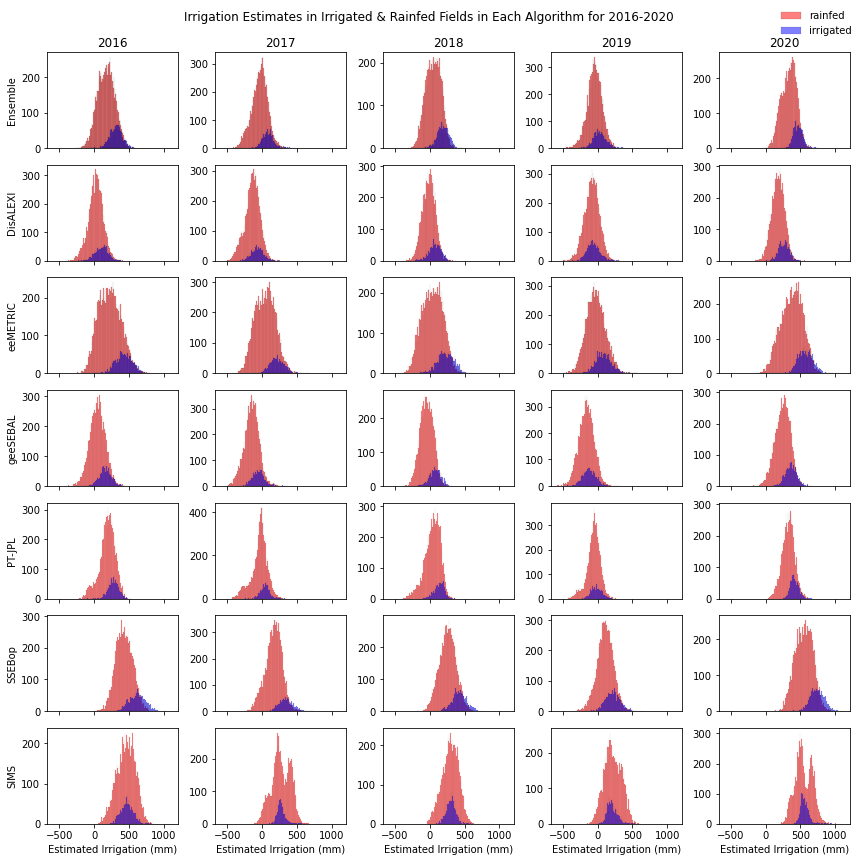

In [161]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 5, sharex=True, figsize = (12, 12))
fig.suptitle('Irrigation Estimates in Irrigated & Rainfed Fields in Each Algorithm for 2016-2020', y=0.99)
fig.patch.set_facecolor('white')

sns.histplot(ax=axs[0,0], data=rain_mean_ensemble_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,0], data=irr_mean_ensemble_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,1], data=rain_mean_ensemble_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,1], data=irr_mean_ensemble_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,2], data=rain_mean_ensemble_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,2], data=irr_mean_ensemble_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,3], data=rain_mean_ensemble_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,3], data=irr_mean_ensemble_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,4], data=rain_mean_ensemble_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,4], data=irr_mean_ensemble_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,0], data=rain_mean_disalexi_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,0], data=irr_mean_disalexi_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,1], data=rain_mean_disalexi_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,1], data=irr_mean_disalexi_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,2], data=rain_mean_disalexi_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,2], data=irr_mean_disalexi_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,3], data=rain_mean_disalexi_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,3], data=irr_mean_disalexi_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,4], data=rain_mean_disalexi_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,4], data=irr_mean_disalexi_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,0], data=rain_mean_eemetric_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,0], data=irr_mean_eemetric_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,1], data=rain_mean_eemetric_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,1], data=irr_mean_eemetric_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,2], data=rain_mean_eemetric_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,2], data=irr_mean_eemetric_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,3], data=rain_mean_eemetric_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,3], data=irr_mean_eemetric_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,4], data=rain_mean_eemetric_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,4], data=irr_mean_eemetric_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,0], data=rain_mean_geesebal_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,0], data=irr_mean_geesebal_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,1], data=rain_mean_geesebal_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,1], data=irr_mean_geesebal_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,2], data=rain_mean_geesebal_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,2], data=irr_mean_geesebal_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,3], data=rain_mean_geesebal_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,3], data=irr_mean_geesebal_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,4], data=rain_mean_geesebal_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,4], data=irr_mean_geesebal_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,0], data=rain_mean_ptjpl_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,0], data=irr_mean_ptjpl_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,1], data=rain_mean_ptjpl_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,1], data=irr_mean_ptjpl_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,2], data=rain_mean_ptjpl_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,2], data=irr_mean_ptjpl_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,3], data=rain_mean_ptjpl_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,3], data=irr_mean_ptjpl_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,4], data=rain_mean_ptjpl_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,4], data=irr_mean_ptjpl_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,0], data=rain_mean_ssebop_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,0], data=irr_mean_ssebop_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,1], data=rain_mean_ssebop_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,1], data=irr_mean_ssebop_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,2], data=rain_mean_ssebop_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,2], data=irr_mean_ssebop_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,3], data=rain_mean_ssebop_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,3], data=irr_mean_ssebop_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,4], data=rain_mean_ssebop_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,4], data=irr_mean_ssebop_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,0], data=rain_mean_sims_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,0], data=irr_mean_sims_fields_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,1], data=rain_mean_sims_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,1], data=irr_mean_sims_fields_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,2], data=rain_mean_sims_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,2], data=irr_mean_sims_fields_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,3], data=rain_mean_sims_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,3], data=irr_mean_sims_fields_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,4], data=rain_mean_sims_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,4], data=irr_mean_sims_fields_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
ax=axs[0,0].set_ylabel('Ensemble')
ax=axs[0,1].set_ylabel('')
ax=axs[0,2].set_ylabel('')
ax=axs[0,3].set_ylabel('')
ax=axs[0,4].set_ylabel('')
ax=axs[1,0].set_ylabel('DisALEXI')
ax=axs[1,1].set_ylabel('')
ax=axs[1,2].set_ylabel('')
ax=axs[1,3].set_ylabel('')
ax=axs[1,4].set_ylabel('')
ax=axs[2,0].set_ylabel('eeMETRIC')
ax=axs[2,1].set_ylabel('')
ax=axs[2,2].set_ylabel('')
ax=axs[2,3].set_ylabel('')
ax=axs[2,4].set_ylabel('')
ax=axs[3,0].set_ylabel('geeSEBAL')
ax=axs[3,1].set_ylabel('')
ax=axs[3,2].set_ylabel('')
ax=axs[3,3].set_ylabel('')
ax=axs[3,4].set_ylabel('')
ax=axs[4,0].set_ylabel('PT-JPL')
ax=axs[4,1].set_ylabel('')
ax=axs[4,2].set_ylabel('')
ax=axs[4,3].set_ylabel('')
ax=axs[4,4].set_ylabel('')
ax=axs[5,0].set_ylabel('SSEBop')
ax=axs[5,1].set_ylabel('')
ax=axs[5,2].set_ylabel('')
ax=axs[5,3].set_ylabel('')
ax=axs[5,4].set_ylabel('')
ax=axs[6,0].set_ylabel('SIMS')
ax=axs[6,1].set_ylabel('')
ax=axs[6,2].set_ylabel('')
ax=axs[6,3].set_ylabel('')
ax=axs[6,4].set_ylabel('')
ax=axs[0,0].set_xlabel('')
ax=axs[0,1].set_xlabel('')
ax=axs[0,2].set_xlabel('')
ax=axs[0,3].set_xlabel('')
ax=axs[0,4].set_xlabel('')
ax=axs[1,0].set_xlabel('')
ax=axs[1,1].set_xlabel('')
ax=axs[1,2].set_xlabel('')
ax=axs[1,3].set_xlabel('')
ax=axs[1,4].set_xlabel('')
ax=axs[2,0].set_xlabel('')
ax=axs[2,1].set_xlabel('')
ax=axs[2,2].set_xlabel('')
ax=axs[2,3].set_xlabel('')
ax=axs[2,4].set_xlabel('')
ax=axs[3,0].set_xlabel('')
ax=axs[3,1].set_xlabel('')
ax=axs[3,2].set_xlabel('')
ax=axs[3,3].set_xlabel('')
ax=axs[3,4].set_xlabel('')
ax=axs[4,1].set_xlabel('')
ax=axs[4,2].set_xlabel('')
ax=axs[4,3].set_xlabel('')
ax=axs[4,4].set_xlabel('')
ax=axs[5,0].set_xlabel('')
ax=axs[5,1].set_xlabel('')
ax=axs[5,2].set_xlabel('')
ax=axs[5,3].set_xlabel('')
ax=axs[5,4].set_xlabel('')
ax=axs[6,0].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,1].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,2].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,3].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,4].set_xlabel('Estimated Irrigation (mm)')
axs[0,0].set_title('2016')
axs[0,1].set_title('2017')
axs[0,2].set_title('2018')
axs[0,3].set_title('2019')
axs[0,4].set_title('2020')

lines, labels = fig.axes[0].get_legend_handles_labels()
legend = fig.legend(lines, labels, loc = 'upper right', bbox_to_anchor=(0.0005, 0., 1, 1))

frame = legend.get_frame()
frame.set_facecolor('none')
frame.set_edgecolor('none')

fig.tight_layout()

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\')
plt.savefig('fieldsIrrigationEstimates.png', dpi=500)
plt.show()

### Corn Histograms

Separate the CDL data by year

In [258]:
cdl_2016 = cdl[cdl['Year'] == 2016]
cdl_2017 = cdl[cdl['Year'] == 2017]
cdl_2018 = cdl[cdl['Year'] == 2018]
cdl_2019 = cdl[cdl['Year'] == 2019]
cdl_2020 = cdl[cdl['Year'] == 2020]

# Make a list with the different years
cdl_years = [cdl_2016, cdl_2017, cdl_2018, cdl_2019, cdl_2020]

Subset the data to the fields only producing corn by algorithm

In [289]:
# Irrigated Corn Mean Ensemble
irr_corn_mean_ensemble = {}

irr_mean_ensemble_fields = [irr_mean_ensemble_fields_2016, 
                            irr_mean_ensemble_fields_2017, 
                            irr_mean_ensemble_fields_2018, 
                            irr_mean_ensemble_fields_2019, 
                            irr_mean_ensemble_fields_2020]
irr_corn_mean_ensemble_lab = ['corn_irr_mean_ensemble_2016', 
                              'corn_irr_mean_ensemble_2017', 
                              'corn_irr_mean_ensemble_2018', 
                              'corn_irr_mean_ensemble_2019', 
                              'corn_irr_mean_ensemble_2020']

for (x, y, z) in zip(cdl_years, irr_mean_ensemble_fields, irr_corn_mean_ensemble_lab):
    irr_mean_ensemble_corn = y.merge(x, on='UID')
    irr_mean_ensemble_corn = irr_mean_ensemble_corn.merge(crops, on='CropCode')
    irr_corn_mean_ensemble[z] = irr_mean_ensemble_corn[irr_mean_ensemble_corn['CropGroup'] == 'Corn']
    
irr_mean_ensemble_corn_2016 = irr_corn_mean_ensemble['corn_irr_mean_ensemble_2016']
irr_mean_ensemble_corn_2017 = irr_corn_mean_ensemble['corn_irr_mean_ensemble_2017']
irr_mean_ensemble_corn_2018 = irr_corn_mean_ensemble['corn_irr_mean_ensemble_2018']
irr_mean_ensemble_corn_2019 = irr_corn_mean_ensemble['corn_irr_mean_ensemble_2019']
irr_mean_ensemble_corn_2020 = irr_corn_mean_ensemble['corn_irr_mean_ensemble_2020']

# Rainfed Corn Mean Ensemble
rain_corn_mean_ensemble = {}

rain_mean_ensemble_fields = [rain_mean_ensemble_fields_2016, 
                            rain_mean_ensemble_fields_2017, 
                            rain_mean_ensemble_fields_2018, 
                            rain_mean_ensemble_fields_2019, 
                            rain_mean_ensemble_fields_2020]
rain_corn_mean_ensemble_lab = ['corn_rain_mean_ensemble_2016', 
                              'corn_rain_mean_ensemble_2017', 
                              'corn_rain_mean_ensemble_2018', 
                              'corn_rain_mean_ensemble_2019', 
                              'corn_rain_mean_ensemble_2020']

for (x, y, z) in zip(cdl_years, rain_mean_ensemble_fields, rain_corn_mean_ensemble_lab):
    rain_mean_ensemble_corn = y.merge(x, on='UID')
    rain_mean_ensemble_corn = rain_mean_ensemble_corn.merge(crops, on='CropCode')
    rain_corn_mean_ensemble[z] = rain_mean_ensemble_corn[rain_mean_ensemble_corn['CropGroup'] == 'Corn']
    
rain_mean_ensemble_corn_2016 = rain_corn_mean_ensemble['corn_rain_mean_ensemble_2016']
rain_mean_ensemble_corn_2017 = rain_corn_mean_ensemble['corn_rain_mean_ensemble_2017']
rain_mean_ensemble_corn_2018 = rain_corn_mean_ensemble['corn_rain_mean_ensemble_2018']
rain_mean_ensemble_corn_2019 = rain_corn_mean_ensemble['corn_rain_mean_ensemble_2019']
rain_mean_ensemble_corn_2020 = rain_corn_mean_ensemble['corn_rain_mean_ensemble_2020']

Simplifying the histograms even more to just the LEMA

In [365]:
irr_mean_ensemble_corn_lema_2016 = lema.merge(irr_mean_ensemble_corn_2016, on='UID')
irr_mean_ensemble_corn_lema_2017 = lema.merge(irr_mean_ensemble_corn_2017, on='UID')
irr_mean_ensemble_corn_lema_2018 = lema.merge(irr_mean_ensemble_corn_2018, on='UID')
irr_mean_ensemble_corn_lema_2019 = lema.merge(irr_mean_ensemble_corn_2019, on='UID')
irr_mean_ensemble_corn_lema_2020 = lema.merge(irr_mean_ensemble_corn_2020, on='UID')

rain_mean_ensemble_corn_lema_2016 = lema.merge(rain_mean_ensemble_corn_2016, on='UID')
rain_mean_ensemble_corn_lema_2017 = lema.merge(rain_mean_ensemble_corn_2017, on='UID')
rain_mean_ensemble_corn_lema_2018 = lema.merge(rain_mean_ensemble_corn_2018, on='UID')
rain_mean_ensemble_corn_lema_2019 = lema.merge(rain_mean_ensemble_corn_2019, on='UID')
rain_mean_ensemble_corn_lema_2020 = lema.merge(rain_mean_ensemble_corn_2020, on='UID')

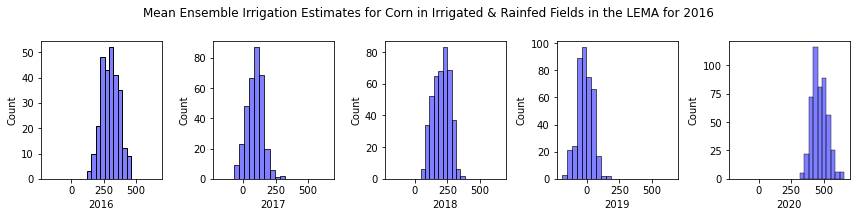

In [373]:
fig, axs = plt.subplots(nrows = 1, ncols = 5, sharex=True, figsize = (12, 3))
fig.suptitle('Mean Ensemble Irrigation Estimates for Corn in Irrigated & Rainfed Fields in the LEMA for 2016', y=0.99)
fig.patch.set_facecolor('white')

sns.histplot(ax=axs[0], data=irr_mean_ensemble_corn_lema_2016, x='2016', alpha = 0.5, bins=10, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1], data=irr_mean_ensemble_corn_lema_2017, x='2017', alpha = 0.5, bins=10, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2], data=irr_mean_ensemble_corn_lema_2018, x='2018', alpha = 0.5, bins=10, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3], data=irr_mean_ensemble_corn_lema_2019, x='2019', alpha = 0.5, bins=10, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4], data=irr_mean_ensemble_corn_lema_2020, x='2020', alpha = 0.5, bins=10, label = 'irrigated', color='Blue')

# sns.histplot(ax=axs[0], data=rain_mean_ensemble_corn_lema_2016, x='2016', alpha = 0.5, bins=10, label = 'rainfed', color='Red')
# sns.histplot(ax=axs[1], data=rain_mean_ensemble_corn_lema_2017, x='2017', alpha = 0.5, bins=10, label = 'rainfed', color='Red')
# sns.histplot(ax=axs[2], data=rain_mean_ensemble_corn_lema_2018, x='2018', alpha = 0.5, bins=10, label = 'rainfed', color='Red')
# sns.histplot(ax=axs[3], data=rain_mean_ensemble_corn_lema_2019, x='2019', alpha = 0.5, bins=10, label = 'rainfed', color='Red')
# sns.histplot(ax=axs[4], data=rain_mean_ensemble_corn_lema_2020, x='2020', alpha = 0.5, bins=10, label = 'rainfed', color='Red')

fig.tight_layout()

In [268]:
# Irrigated Corn Mean disalexi
irr_corn_mean_disalexi = {}

irr_mean_disalexi_fields = [irr_mean_disalexi_fields_2016, 
                            irr_mean_disalexi_fields_2017, 
                            irr_mean_disalexi_fields_2018, 
                            irr_mean_disalexi_fields_2019, 
                            irr_mean_disalexi_fields_2020]
irr_corn_mean_disalexi_lab = ['corn_irr_mean_disalexi_2016', 
                              'corn_irr_mean_disalexi_2017', 
                              'corn_irr_mean_disalexi_2018', 
                              'corn_irr_mean_disalexi_2019', 
                              'corn_irr_mean_disalexi_2020']

for (x, y, z) in zip(cdl_years, irr_mean_disalexi_fields, irr_corn_mean_disalexi_lab):
    irr_mean_disalexi_corn = y.merge(x, on='UID')
    irr_mean_disalexi_corn = irr_mean_disalexi_corn.merge(crops, on='CropCode')
    irr_corn_mean_disalexi[z] = irr_mean_disalexi_corn[irr_mean_disalexi_corn['CropGroup'] == 'Corn']
    
irr_mean_disalexi_corn_2016 = irr_corn_mean_disalexi['corn_irr_mean_disalexi_2016']
irr_mean_disalexi_corn_2017 = irr_corn_mean_disalexi['corn_irr_mean_disalexi_2017']
irr_mean_disalexi_corn_2018 = irr_corn_mean_disalexi['corn_irr_mean_disalexi_2018']
irr_mean_disalexi_corn_2019 = irr_corn_mean_disalexi['corn_irr_mean_disalexi_2019']
irr_mean_disalexi_corn_2020 = irr_corn_mean_disalexi['corn_irr_mean_disalexi_2020']

# Rainfed Corn Mean disalexi
rain_corn_mean_disalexi = {}

rain_mean_disalexi_fields = [rain_mean_disalexi_fields_2016, 
                            rain_mean_disalexi_fields_2017, 
                            rain_mean_disalexi_fields_2018, 
                            rain_mean_disalexi_fields_2019, 
                            rain_mean_disalexi_fields_2020]
rain_corn_mean_disalexi_lab = ['corn_rain_mean_disalexi_2016', 
                              'corn_rain_mean_disalexi_2017', 
                              'corn_rain_mean_disalexi_2018', 
                              'corn_rain_mean_disalexi_2019', 
                              'corn_rain_mean_disalexi_2020']

for (x, y, z) in zip(cdl_years, rain_mean_disalexi_fields, rain_corn_mean_disalexi_lab):
    rain_mean_disalexi_corn = y.merge(x, on='UID')
    rain_mean_disalexi_corn = rain_mean_disalexi_corn.merge(crops, on='CropCode')
    rain_corn_mean_disalexi[z] = rain_mean_disalexi_corn[rain_mean_disalexi_corn['CropGroup'] == 'Corn']
    
rain_mean_disalexi_corn_2016 = rain_corn_mean_disalexi['corn_rain_mean_disalexi_2016']
rain_mean_disalexi_corn_2017 = rain_corn_mean_disalexi['corn_rain_mean_disalexi_2017']
rain_mean_disalexi_corn_2018 = rain_corn_mean_disalexi['corn_rain_mean_disalexi_2018']
rain_mean_disalexi_corn_2019 = rain_corn_mean_disalexi['corn_rain_mean_disalexi_2019']
rain_mean_disalexi_corn_2020 = rain_corn_mean_disalexi['corn_rain_mean_disalexi_2020']

In [269]:
# Irrigated Corn Mean eemetric
irr_corn_mean_eemetric = {}

irr_mean_eemetric_fields = [irr_mean_eemetric_fields_2016, 
                            irr_mean_eemetric_fields_2017, 
                            irr_mean_eemetric_fields_2018, 
                            irr_mean_eemetric_fields_2019, 
                            irr_mean_eemetric_fields_2020]
irr_corn_mean_eemetric_lab = ['corn_irr_mean_eemetric_2016', 
                              'corn_irr_mean_eemetric_2017', 
                              'corn_irr_mean_eemetric_2018', 
                              'corn_irr_mean_eemetric_2019', 
                              'corn_irr_mean_eemetric_2020']

for (x, y, z) in zip(cdl_years, irr_mean_eemetric_fields, irr_corn_mean_eemetric_lab):
    irr_mean_eemetric_corn = y.merge(x, on='UID')
    irr_mean_eemetric_corn = irr_mean_eemetric_corn.merge(crops, on='CropCode')
    irr_corn_mean_eemetric[z] = irr_mean_eemetric_corn[irr_mean_eemetric_corn['CropGroup'] == 'Corn']
    
irr_mean_eemetric_corn_2016 = irr_corn_mean_eemetric['corn_irr_mean_eemetric_2016']
irr_mean_eemetric_corn_2017 = irr_corn_mean_eemetric['corn_irr_mean_eemetric_2017']
irr_mean_eemetric_corn_2018 = irr_corn_mean_eemetric['corn_irr_mean_eemetric_2018']
irr_mean_eemetric_corn_2019 = irr_corn_mean_eemetric['corn_irr_mean_eemetric_2019']
irr_mean_eemetric_corn_2020 = irr_corn_mean_eemetric['corn_irr_mean_eemetric_2020']

# Rainfed Corn Mean eemetric
rain_corn_mean_eemetric = {}

rain_mean_eemetric_fields = [rain_mean_eemetric_fields_2016, 
                            rain_mean_eemetric_fields_2017, 
                            rain_mean_eemetric_fields_2018, 
                            rain_mean_eemetric_fields_2019, 
                            rain_mean_eemetric_fields_2020]
rain_corn_mean_eemetric_lab = ['corn_rain_mean_eemetric_2016', 
                              'corn_rain_mean_eemetric_2017', 
                              'corn_rain_mean_eemetric_2018', 
                              'corn_rain_mean_eemetric_2019', 
                              'corn_rain_mean_eemetric_2020']

for (x, y, z) in zip(cdl_years, rain_mean_eemetric_fields, rain_corn_mean_eemetric_lab):
    rain_mean_eemetric_corn = y.merge(x, on='UID')
    rain_mean_eemetric_corn = rain_mean_eemetric_corn.merge(crops, on='CropCode')
    rain_corn_mean_eemetric[z] = rain_mean_eemetric_corn[rain_mean_eemetric_corn['CropGroup'] == 'Corn']
    
rain_mean_eemetric_corn_2016 = rain_corn_mean_eemetric['corn_rain_mean_eemetric_2016']
rain_mean_eemetric_corn_2017 = rain_corn_mean_eemetric['corn_rain_mean_eemetric_2017']
rain_mean_eemetric_corn_2018 = rain_corn_mean_eemetric['corn_rain_mean_eemetric_2018']
rain_mean_eemetric_corn_2019 = rain_corn_mean_eemetric['corn_rain_mean_eemetric_2019']
rain_mean_eemetric_corn_2020 = rain_corn_mean_eemetric['corn_rain_mean_eemetric_2020']

In [270]:
# Irrigated Corn Mean geesebal
irr_corn_mean_geesebal = {}

irr_mean_geesebal_fields = [irr_mean_geesebal_fields_2016, 
                            irr_mean_geesebal_fields_2017, 
                            irr_mean_geesebal_fields_2018, 
                            irr_mean_geesebal_fields_2019, 
                            irr_mean_geesebal_fields_2020]
irr_corn_mean_geesebal_lab = ['corn_irr_mean_geesebal_2016', 
                              'corn_irr_mean_geesebal_2017', 
                              'corn_irr_mean_geesebal_2018', 
                              'corn_irr_mean_geesebal_2019', 
                              'corn_irr_mean_geesebal_2020']

for (x, y, z) in zip(cdl_years, irr_mean_geesebal_fields, irr_corn_mean_geesebal_lab):
    irr_mean_geesebal_corn = y.merge(x, on='UID')
    irr_mean_geesebal_corn = irr_mean_geesebal_corn.merge(crops, on='CropCode')
    irr_corn_mean_geesebal[z] = irr_mean_geesebal_corn[irr_mean_geesebal_corn['CropGroup'] == 'Corn']
    
irr_mean_geesebal_corn_2016 = irr_corn_mean_geesebal['corn_irr_mean_geesebal_2016']
irr_mean_geesebal_corn_2017 = irr_corn_mean_geesebal['corn_irr_mean_geesebal_2017']
irr_mean_geesebal_corn_2018 = irr_corn_mean_geesebal['corn_irr_mean_geesebal_2018']
irr_mean_geesebal_corn_2019 = irr_corn_mean_geesebal['corn_irr_mean_geesebal_2019']
irr_mean_geesebal_corn_2020 = irr_corn_mean_geesebal['corn_irr_mean_geesebal_2020']

# Rainfed Corn Mean geesebal
rain_corn_mean_geesebal = {}

rain_mean_geesebal_fields = [rain_mean_geesebal_fields_2016, 
                            rain_mean_geesebal_fields_2017, 
                            rain_mean_geesebal_fields_2018, 
                            rain_mean_geesebal_fields_2019, 
                            rain_mean_geesebal_fields_2020]
rain_corn_mean_geesebal_lab = ['corn_rain_mean_geesebal_2016', 
                              'corn_rain_mean_geesebal_2017', 
                              'corn_rain_mean_geesebal_2018', 
                              'corn_rain_mean_geesebal_2019', 
                              'corn_rain_mean_geesebal_2020']

for (x, y, z) in zip(cdl_years, rain_mean_geesebal_fields, rain_corn_mean_geesebal_lab):
    rain_mean_geesebal_corn = y.merge(x, on='UID')
    rain_mean_geesebal_corn = rain_mean_geesebal_corn.merge(crops, on='CropCode')
    rain_corn_mean_geesebal[z] = rain_mean_geesebal_corn[rain_mean_geesebal_corn['CropGroup'] == 'Corn']
    
rain_mean_geesebal_corn_2016 = rain_corn_mean_geesebal['corn_rain_mean_geesebal_2016']
rain_mean_geesebal_corn_2017 = rain_corn_mean_geesebal['corn_rain_mean_geesebal_2017']
rain_mean_geesebal_corn_2018 = rain_corn_mean_geesebal['corn_rain_mean_geesebal_2018']
rain_mean_geesebal_corn_2019 = rain_corn_mean_geesebal['corn_rain_mean_geesebal_2019']
rain_mean_geesebal_corn_2020 = rain_corn_mean_geesebal['corn_rain_mean_geesebal_2020']

In [271]:
# Irrigated Corn Mean ptjpl
irr_corn_mean_ptjpl = {}

irr_mean_ptjpl_fields = [irr_mean_ptjpl_fields_2016, 
                            irr_mean_ptjpl_fields_2017, 
                            irr_mean_ptjpl_fields_2018, 
                            irr_mean_ptjpl_fields_2019, 
                            irr_mean_ptjpl_fields_2020]
irr_corn_mean_ptjpl_lab = ['corn_irr_mean_ptjpl_2016', 
                              'corn_irr_mean_ptjpl_2017', 
                              'corn_irr_mean_ptjpl_2018', 
                              'corn_irr_mean_ptjpl_2019', 
                              'corn_irr_mean_ptjpl_2020']

for (x, y, z) in zip(cdl_years, irr_mean_ptjpl_fields, irr_corn_mean_ptjpl_lab):
    irr_mean_ptjpl_corn = y.merge(x, on='UID')
    irr_mean_ptjpl_corn = irr_mean_ptjpl_corn.merge(crops, on='CropCode')
    irr_corn_mean_ptjpl[z] = irr_mean_ptjpl_corn[irr_mean_ptjpl_corn['CropGroup'] == 'Corn']
    
irr_mean_ptjpl_corn_2016 = irr_corn_mean_ptjpl['corn_irr_mean_ptjpl_2016']
irr_mean_ptjpl_corn_2017 = irr_corn_mean_ptjpl['corn_irr_mean_ptjpl_2017']
irr_mean_ptjpl_corn_2018 = irr_corn_mean_ptjpl['corn_irr_mean_ptjpl_2018']
irr_mean_ptjpl_corn_2019 = irr_corn_mean_ptjpl['corn_irr_mean_ptjpl_2019']
irr_mean_ptjpl_corn_2020 = irr_corn_mean_ptjpl['corn_irr_mean_ptjpl_2020']

# Rainfed Corn Mean ptjpl
rain_corn_mean_ptjpl = {}

rain_mean_ptjpl_fields = [rain_mean_ptjpl_fields_2016, 
                            rain_mean_ptjpl_fields_2017, 
                            rain_mean_ptjpl_fields_2018, 
                            rain_mean_ptjpl_fields_2019, 
                            rain_mean_ptjpl_fields_2020]
rain_corn_mean_ptjpl_lab = ['corn_rain_mean_ptjpl_2016', 
                              'corn_rain_mean_ptjpl_2017', 
                              'corn_rain_mean_ptjpl_2018', 
                              'corn_rain_mean_ptjpl_2019', 
                              'corn_rain_mean_ptjpl_2020']

for (x, y, z) in zip(cdl_years, rain_mean_ptjpl_fields, rain_corn_mean_ptjpl_lab):
    rain_mean_ptjpl_corn = y.merge(x, on='UID')
    rain_mean_ptjpl_corn = rain_mean_ptjpl_corn.merge(crops, on='CropCode')
    rain_corn_mean_ptjpl[z] = rain_mean_ptjpl_corn[rain_mean_ptjpl_corn['CropGroup'] == 'Corn']
    
rain_mean_ptjpl_corn_2016 = rain_corn_mean_ptjpl['corn_rain_mean_ptjpl_2016']
rain_mean_ptjpl_corn_2017 = rain_corn_mean_ptjpl['corn_rain_mean_ptjpl_2017']
rain_mean_ptjpl_corn_2018 = rain_corn_mean_ptjpl['corn_rain_mean_ptjpl_2018']
rain_mean_ptjpl_corn_2019 = rain_corn_mean_ptjpl['corn_rain_mean_ptjpl_2019']
rain_mean_ptjpl_corn_2020 = rain_corn_mean_ptjpl['corn_rain_mean_ptjpl_2020']

In [272]:
# Irrigated Corn Mean ssebop
irr_corn_mean_ssebop = {}

irr_mean_ssebop_fields = [irr_mean_ssebop_fields_2016, 
                            irr_mean_ssebop_fields_2017, 
                            irr_mean_ssebop_fields_2018, 
                            irr_mean_ssebop_fields_2019, 
                            irr_mean_ssebop_fields_2020]
irr_corn_mean_ssebop_lab = ['corn_irr_mean_ssebop_2016', 
                              'corn_irr_mean_ssebop_2017', 
                              'corn_irr_mean_ssebop_2018', 
                              'corn_irr_mean_ssebop_2019', 
                              'corn_irr_mean_ssebop_2020']

for (x, y, z) in zip(cdl_years, irr_mean_ssebop_fields, irr_corn_mean_ssebop_lab):
    irr_mean_ssebop_corn = y.merge(x, on='UID')
    irr_mean_ssebop_corn = irr_mean_ssebop_corn.merge(crops, on='CropCode')
    irr_corn_mean_ssebop[z] = irr_mean_ssebop_corn[irr_mean_ssebop_corn['CropGroup'] == 'Corn']
    
irr_mean_ssebop_corn_2016 = irr_corn_mean_ssebop['corn_irr_mean_ssebop_2016']
irr_mean_ssebop_corn_2017 = irr_corn_mean_ssebop['corn_irr_mean_ssebop_2017']
irr_mean_ssebop_corn_2018 = irr_corn_mean_ssebop['corn_irr_mean_ssebop_2018']
irr_mean_ssebop_corn_2019 = irr_corn_mean_ssebop['corn_irr_mean_ssebop_2019']
irr_mean_ssebop_corn_2020 = irr_corn_mean_ssebop['corn_irr_mean_ssebop_2020']

# Rainfed Corn Mean ssebop
rain_corn_mean_ssebop = {}

rain_mean_ssebop_fields = [rain_mean_ssebop_fields_2016, 
                            rain_mean_ssebop_fields_2017, 
                            rain_mean_ssebop_fields_2018, 
                            rain_mean_ssebop_fields_2019, 
                            rain_mean_ssebop_fields_2020]
rain_corn_mean_ssebop_lab = ['corn_rain_mean_ssebop_2016', 
                              'corn_rain_mean_ssebop_2017', 
                              'corn_rain_mean_ssebop_2018', 
                              'corn_rain_mean_ssebop_2019', 
                              'corn_rain_mean_ssebop_2020']

for (x, y, z) in zip(cdl_years, rain_mean_ssebop_fields, rain_corn_mean_ssebop_lab):
    rain_mean_ssebop_corn = y.merge(x, on='UID')
    rain_mean_ssebop_corn = rain_mean_ssebop_corn.merge(crops, on='CropCode')
    rain_corn_mean_ssebop[z] = rain_mean_ssebop_corn[rain_mean_ssebop_corn['CropGroup'] == 'Corn']
    
rain_mean_ssebop_corn_2016 = rain_corn_mean_ssebop['corn_rain_mean_ssebop_2016']
rain_mean_ssebop_corn_2017 = rain_corn_mean_ssebop['corn_rain_mean_ssebop_2017']
rain_mean_ssebop_corn_2018 = rain_corn_mean_ssebop['corn_rain_mean_ssebop_2018']
rain_mean_ssebop_corn_2019 = rain_corn_mean_ssebop['corn_rain_mean_ssebop_2019']
rain_mean_ssebop_corn_2020 = rain_corn_mean_ssebop['corn_rain_mean_ssebop_2020']

In [273]:
# Irrigated Corn Mean sims
irr_corn_mean_sims = {}

irr_mean_sims_fields = [irr_mean_sims_fields_2016, 
                            irr_mean_sims_fields_2017, 
                            irr_mean_sims_fields_2018, 
                            irr_mean_sims_fields_2019, 
                            irr_mean_sims_fields_2020]
irr_corn_mean_sims_lab = ['corn_irr_mean_sims_2016', 
                              'corn_irr_mean_sims_2017', 
                              'corn_irr_mean_sims_2018', 
                              'corn_irr_mean_sims_2019', 
                              'corn_irr_mean_sims_2020']

for (x, y, z) in zip(cdl_years, irr_mean_sims_fields, irr_corn_mean_sims_lab):
    irr_mean_sims_corn = y.merge(x, on='UID')
    irr_mean_sims_corn = irr_mean_sims_corn.merge(crops, on='CropCode')
    irr_corn_mean_sims[z] = irr_mean_sims_corn[irr_mean_sims_corn['CropGroup'] == 'Corn']
    
irr_mean_sims_corn_2016 = irr_corn_mean_sims['corn_irr_mean_sims_2016']
irr_mean_sims_corn_2017 = irr_corn_mean_sims['corn_irr_mean_sims_2017']
irr_mean_sims_corn_2018 = irr_corn_mean_sims['corn_irr_mean_sims_2018']
irr_mean_sims_corn_2019 = irr_corn_mean_sims['corn_irr_mean_sims_2019']
irr_mean_sims_corn_2020 = irr_corn_mean_sims['corn_irr_mean_sims_2020']

# Rainfed Corn Mean sims
rain_corn_mean_sims = {}

rain_mean_sims_fields = [rain_mean_sims_fields_2016, 
                            rain_mean_sims_fields_2017, 
                            rain_mean_sims_fields_2018, 
                            rain_mean_sims_fields_2019, 
                            rain_mean_sims_fields_2020]
rain_corn_mean_sims_lab = ['corn_rain_mean_sims_2016', 
                              'corn_rain_mean_sims_2017', 
                              'corn_rain_mean_sims_2018', 
                              'corn_rain_mean_sims_2019', 
                              'corn_rain_mean_sims_2020']

for (x, y, z) in zip(cdl_years, rain_mean_sims_fields, rain_corn_mean_sims_lab):
    rain_mean_sims_corn = y.merge(x, on='UID')
    rain_mean_sims_corn = rain_mean_sims_corn.merge(crops, on='CropCode')
    rain_corn_mean_sims[z] = rain_mean_sims_corn[rain_mean_sims_corn['CropGroup'] == 'Corn']
    
rain_mean_sims_corn_2016 = rain_corn_mean_sims['corn_rain_mean_sims_2016']
rain_mean_sims_corn_2017 = rain_corn_mean_sims['corn_rain_mean_sims_2017']
rain_mean_sims_corn_2018 = rain_corn_mean_sims['corn_rain_mean_sims_2018']
rain_mean_sims_corn_2019 = rain_corn_mean_sims['corn_rain_mean_sims_2019']
rain_mean_sims_corn_2020 = rain_corn_mean_sims['corn_rain_mean_sims_2020']

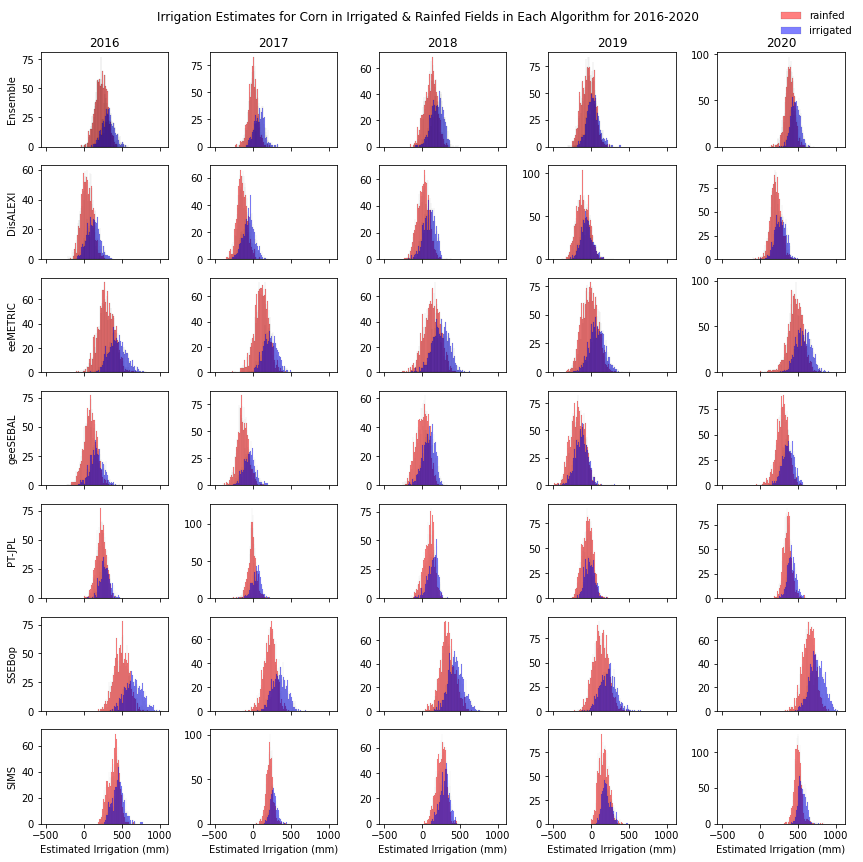

In [337]:
# Create figure and set axes
fig, axs = plt.subplots(nrows = 7, ncols = 5, sharex=True, figsize = (12, 12))
fig.suptitle('Irrigation Estimates for Corn in Irrigated & Rainfed Fields in Each Algorithm for 2016-2020', y=0.99)
fig.patch.set_facecolor('white')

sns.histplot(ax=axs[0,0], data=rain_mean_ensemble_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,0], data=irr_mean_ensemble_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,1], data=rain_mean_ensemble_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,1], data=irr_mean_ensemble_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,2], data=rain_mean_ensemble_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,2], data=irr_mean_ensemble_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,3], data=rain_mean_ensemble_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,3], data=irr_mean_ensemble_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[0,4], data=rain_mean_ensemble_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[0,4], data=irr_mean_ensemble_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,0], data=rain_mean_disalexi_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,0], data=irr_mean_disalexi_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,1], data=rain_mean_disalexi_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,1], data=irr_mean_disalexi_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,2], data=rain_mean_disalexi_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,2], data=irr_mean_disalexi_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,3], data=rain_mean_disalexi_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,3], data=irr_mean_disalexi_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[1,4], data=rain_mean_disalexi_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[1,4], data=irr_mean_disalexi_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,0], data=rain_mean_eemetric_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,0], data=irr_mean_eemetric_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,1], data=rain_mean_eemetric_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,1], data=irr_mean_eemetric_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,2], data=rain_mean_eemetric_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,2], data=irr_mean_eemetric_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,3], data=rain_mean_eemetric_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,3], data=irr_mean_eemetric_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[2,4], data=rain_mean_eemetric_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[2,4], data=irr_mean_eemetric_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,0], data=rain_mean_geesebal_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,0], data=irr_mean_geesebal_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,1], data=rain_mean_geesebal_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,1], data=irr_mean_geesebal_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,2], data=rain_mean_geesebal_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,2], data=irr_mean_geesebal_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,3], data=rain_mean_geesebal_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,3], data=irr_mean_geesebal_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[3,4], data=rain_mean_geesebal_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[3,4], data=irr_mean_geesebal_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,0], data=rain_mean_ptjpl_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,0], data=irr_mean_ptjpl_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,1], data=rain_mean_ptjpl_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,1], data=irr_mean_ptjpl_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,2], data=rain_mean_ptjpl_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,2], data=irr_mean_ptjpl_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,3], data=rain_mean_ptjpl_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,3], data=irr_mean_ptjpl_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[4,4], data=rain_mean_ptjpl_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[4,4], data=irr_mean_ptjpl_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,0], data=rain_mean_ssebop_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,0], data=irr_mean_ssebop_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,1], data=rain_mean_ssebop_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,1], data=irr_mean_ssebop_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,2], data=rain_mean_ssebop_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,2], data=irr_mean_ssebop_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,3], data=rain_mean_ssebop_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,3], data=irr_mean_ssebop_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[5,4], data=rain_mean_ssebop_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[5,4], data=irr_mean_ssebop_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,0], data=rain_mean_sims_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,0], data=irr_mean_sims_corn_2016, x='2016', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,1], data=rain_mean_sims_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,1], data=irr_mean_sims_corn_2017, x='2017', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,2], data=rain_mean_sims_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,2], data=irr_mean_sims_corn_2018, x='2018', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,3], data=rain_mean_sims_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,3], data=irr_mean_sims_corn_2019, x='2019', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
sns.histplot(ax=axs[6,4], data=rain_mean_sims_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'rainfed', color='Red')
sns.histplot(ax=axs[6,4], data=irr_mean_sims_corn_2020, x='2020', alpha = 0.5, bins=100, label = 'irrigated', color='Blue')
ax=axs[0,0].set_ylabel('Ensemble')
ax=axs[0,1].set_ylabel('')
ax=axs[0,2].set_ylabel('')
ax=axs[0,3].set_ylabel('')
ax=axs[0,4].set_ylabel('')
ax=axs[1,0].set_ylabel('DisALEXI')
ax=axs[1,1].set_ylabel('')
ax=axs[1,2].set_ylabel('')
ax=axs[1,3].set_ylabel('')
ax=axs[1,4].set_ylabel('')
ax=axs[2,0].set_ylabel('eeMETRIC')
ax=axs[2,1].set_ylabel('')
ax=axs[2,2].set_ylabel('')
ax=axs[2,3].set_ylabel('')
ax=axs[2,4].set_ylabel('')
ax=axs[3,0].set_ylabel('geeSEBAL')
ax=axs[3,1].set_ylabel('')
ax=axs[3,2].set_ylabel('')
ax=axs[3,3].set_ylabel('')
ax=axs[3,4].set_ylabel('')
ax=axs[4,0].set_ylabel('PT-JPL')
ax=axs[4,1].set_ylabel('')
ax=axs[4,2].set_ylabel('')
ax=axs[4,3].set_ylabel('')
ax=axs[4,4].set_ylabel('')
ax=axs[5,0].set_ylabel('SSEBop')
ax=axs[5,1].set_ylabel('')
ax=axs[5,2].set_ylabel('')
ax=axs[5,3].set_ylabel('')
ax=axs[5,4].set_ylabel('')
ax=axs[6,0].set_ylabel('SIMS')
ax=axs[6,1].set_ylabel('')
ax=axs[6,2].set_ylabel('')
ax=axs[6,3].set_ylabel('')
ax=axs[6,4].set_ylabel('')
ax=axs[0,0].set_xlabel('')
ax=axs[0,1].set_xlabel('')
ax=axs[0,2].set_xlabel('')
ax=axs[0,3].set_xlabel('')
ax=axs[0,4].set_xlabel('')
ax=axs[1,0].set_xlabel('')
ax=axs[1,1].set_xlabel('')
ax=axs[1,2].set_xlabel('')
ax=axs[1,3].set_xlabel('')
ax=axs[1,4].set_xlabel('')
ax=axs[2,0].set_xlabel('')
ax=axs[2,1].set_xlabel('')
ax=axs[2,2].set_xlabel('')
ax=axs[2,3].set_xlabel('')
ax=axs[2,4].set_xlabel('')
ax=axs[3,0].set_xlabel('')
ax=axs[3,1].set_xlabel('')
ax=axs[3,2].set_xlabel('')
ax=axs[3,3].set_xlabel('')
ax=axs[3,4].set_xlabel('')
ax=axs[4,1].set_xlabel('')
ax=axs[4,2].set_xlabel('')
ax=axs[4,3].set_xlabel('')
ax=axs[4,4].set_xlabel('')
ax=axs[5,0].set_xlabel('')
ax=axs[5,1].set_xlabel('')
ax=axs[5,2].set_xlabel('')
ax=axs[5,3].set_xlabel('')
ax=axs[5,4].set_xlabel('')
ax=axs[6,0].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,1].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,2].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,3].set_xlabel('Estimated Irrigation (mm)')
ax=axs[6,4].set_xlabel('Estimated Irrigation (mm)')
axs[0,0].set_title('2016')
axs[0,1].set_title('2017')
axs[0,2].set_title('2018')
axs[0,3].set_title('2019')
axs[0,4].set_title('2020')

lines, labels = fig.axes[0].get_legend_handles_labels()
legend = fig.legend(lines, labels, loc = 'upper right', bbox_to_anchor=(0.0005, 0., 1, 1))

frame = legend.get_frame()
frame.set_facecolor('none')
frame.set_edgecolor('none')

fig.tight_layout()

os.chdir('C:\\Users\\ashle\\Desktop\\KGS\\eggs\\')
plt.savefig('CornIrrigationEstimates.png', dpi=500)
plt.show()

In [171]:
data = [['2016', 1839, 10531, 7334, 10561, 8057, 10603, 11312, 11314], ['2017', 1702, 5326, 1181, 7535, 1058, 5036, 10402, 11137], ['2018', 1906, 8119, 5778, 7437, 4685, 8139, 11158, 11261], ['2019', 2003, 4379, 2413, 5401, 828, 3273, 9717, 10991], ['2020', 2176, 11313, 11082, 11266, 11172, 11314, 11314, 11314]]

compare = pd.DataFrame(data, columns=['Year', 'Total AIM Irrigated Fields', 'Total Mean Ensemble Irrigated Fields', 'Total Mean DisALEXI Irrigated Fields', 'Total Mean eeMetric Irrigated Fields', 'Total Mean geeSEBAL Irrigated Fields', 'Total Mean PT-JPL Irrigated Fields', 'Total Mean SSEBop Irrigated Fields', 'Total Mean SIMS Irrigated Fields'])
compare

,Year,Total AIM Irrigated Fields,Total Mean Ensemble Irrigated Fields,Total Mean DisALEXI Irrigated Fields,Total Mean eeMetric Irrigated Fields,Total Mean geeSEBAL Irrigated Fields,Total Mean PT-JPL Irrigated Fields,Total Mean SSEBop Irrigated Fields,Total Mean SIMS Irrigated Fields
0,2016,1839,10531,7334,10561,8057,10603,11312,11314
1,2017,1702,5326,1181,7535,1058,5036,10402,11137
2,2018,1906,8119,5778,7437,4685,8139,11158,11261
3,2019,2003,4379,2413,5401,828,3273,9717,10991
4,2020,2176,11313,11082,11266,11172,11314,11314,11314
